# Sequences

### Pick **one** of these two topics.

The lecture notebooks are adapted from the [official repository](https://github.com/fchollet/deep-learning-with-python-notebooks) and can be used as starter code.

---

## 1. Time Series with RNNs


1. Download and prepare the timeseries data from listings 10.1 to 10.7.
    ```
    # !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    # !unzip jena_climate_2009_2016.csv.zip
    ```

2. Build an LSTM network, importing code from the first recurrent baseline section (DLWP, 10.2.5).

3.  Experiment with different hyperparameters to improve the results of advanced RNN models in DLWP 10.4.

4. Suggestions for experiments:

    - Adjust the number of units in each recurrent layer;
    - Try different learning rates;
    - Substitute LSTM layers for GRU layers;
    - Try adding a recurrent regularizer;
    - Try bigger densely connected regressors on top of the recurrent base, or even a stack of dense layers;
    - Try stacking more layers, like in listing 10.23, or make it bidirectional (listing 10.24);    
    - Try and reproduce the non-recurrent results from DLWP 10.2.2 to 10.2.5 and compare those with what you have:
      - The commonsense baseline (listing 10.9);
      - The feedforward net (listing 10.10);
      - The 1D convnet from DLWP p.291.


In [3]:
import os, sys, pathlib
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import YouTubeVideo

import tensorflow as tf

##10.2

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2024-01-14 14:21:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.192.104, 52.216.245.62, 54.231.168.16, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.192.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  42.5MB/s    in 0.3s    

2024-01-14 14:21:15 (42.5 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]



In [5]:
!unzip jena_climate_2009_2016.csv.zip -d jena

Archive:  jena_climate_2009_2016.csv.zip
replace jena/jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace jena/__MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena/__MACOSX/._jena_climate_2009_2016.csv  


In [6]:
base_dir = pathlib.Path("jena")
fname = base_dir / "jena_climate_2009_2016.csv"

with open(fname) as f:
    data = f.read()

lines = data.split("\n")             # split on lines
header = lines[0].split(",")         # first line is our header (split on commas)
lines = lines[1:]                    # our data is all the next lines
for i, feature in enumerate(header): # loop through our header items
    if feature == '"T (degC)"':
        print(f"{i:<2} | \033[1;3m{feature} ← temperature in °C\033[0m")
    else:
        print(f"{i:<2} | {feature}")

print()
print(f"{len(lines)} lines")

0  | "Date Time"
1  | "p (mbar)"
2  | "T (degC)" ← temperature in °C
3  | "Tpot (K)"
4  | "Tdew (degC)"
5  | "rh (%)"
6  | "VPmax (mbar)"
7  | "VPact (mbar)"
8  | "VPdef (mbar)"
9  | "sh (g/kg)"
10 | "H2OC (mmol/mol)"
11 | "rho (g/m**3)"
12 | "wv (m/s)"
13 | "max. wv (m/s)"
14 | "wd (deg)"

420451 lines


In [7]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))   # (len minus the date)

if not os.path.isfile(base_dir / "temperature.npy") and not os.path.isfile(base_dir / "raw_data.npz"):
    print("loading dataset")
    for i, line in enumerate(lines):
        print(f"line {i}/{len(lines)}\r", end="")
        values = [float(x) for x in line.split(",")[1:]] # (don't take the date)
        temperature[i] = values[1]                       # temperature at index 1
        raw_data[i, :] = values[:]
    np.save(base_dir / "temperature.npy", temperature)   # save as binary data
    np.save(base_dir / "raw_data.npy", raw_data)         # (much faster reloads)
else:
    print("loading numpy files")
    temperature = np.load(base_dir / "temperature.npy")
    raw_data = np.load(base_dir / "raw_data.npy")

loading numpy files


PLotting the temperature timeseries:

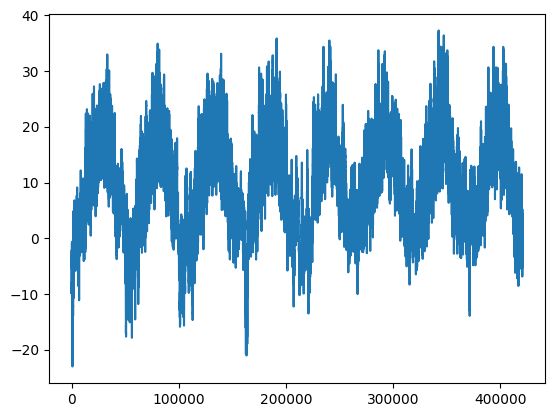

In [ ]:
plt.plot(range(len(temperature)), temperature) # globally cyclical

Plotting the first 10 days of the temperature timeseries:

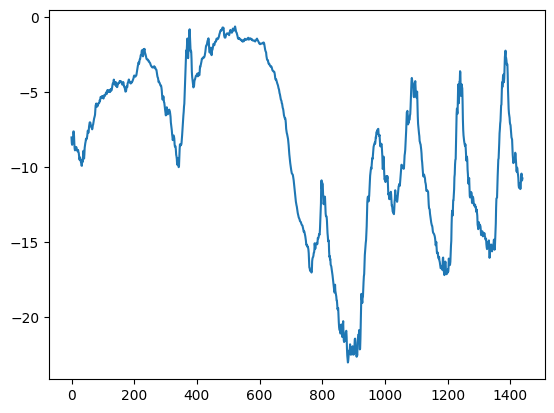

In [ ]:
plt.plot(range(1440), temperature[:1440]) # locally much less so

### Computing the number of samples we'll use for each data split:


In [8]:
num_train_samples = int(0.5 * len(raw_data))                           # 50% for training
num_val_samples = int(0.25 * len(raw_data))                            # 25% for validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples # the rest (25%) for test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

### Normalizing the data

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0) # we use the train data only to normalise
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],   # given our length, stop 3 before the end
    targets=int_sequence[3:], # the first target will be at the fourth element
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("-"*40)
    for i in range(inputs.shape[0]): # loop over batch
        print([int(x) for x in inputs[i]], int(targets[i]))

----------------------------------------
[0, 1, 2] 3
[1, 2, 3] 4
----------------------------------------
[2, 3, 4] 5
[3, 4, 5] 6
----------------------------------------
[4, 5, 6] 7


### Instantiating datasets for training, validation, and testing

In [11]:
sampling_rate = 6                                  # in the data, one sample every 10 mins: x 6 → one per hour
sequence_length = 120                              # the length of our sequence is 5 days (120 hours)
delay = sampling_rate * (sequence_length + 24 - 1) # target is 24h after the end of the sequence (one day after)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],           # not beyond `delay` steps before the end (that's our targets)
    targets=temperature[delay:], # first traget will start at `delay` step after the start
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,                           # start after train
    end_index=num_train_samples + num_val_samples
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples         # start after train & val
)

### Inspecting the output of one of our datasets

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [13]:
def plot_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, label="Training MAE")
    plt.plot(epochs, val_loss, label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

### Computing the common-sense baseline MAE

### 10.2.5

### A simple LSTM-based model

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs) # ← our LSTM
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "jena_lstm.h5"),
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 65s 68ms/step - loss: 46.7018 - mae: 4.9971 - val_loss: 13.6942 - val_mae: 2.8141


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
819/819 [==============================] - 55s 67ms/step - loss: 11.4691 - mae: 2.6254 - val_loss: 9.6481 - val_mae: 2.4189
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 10.0000 - mae: 2.4613 - val_loss: 9.5721 - val_mae: 2.4111
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 9.5590 - mae: 2.4051 - val_loss: 9.7067 - val_mae: 2.4157
Epoch 5/10
819/819 [==============================] - 54s 66ms/step - loss: 9.2541 - mae: 2.3656 - val_loss: 9.6900 - val_mae: 2.4048
Epoch 6/10
819/819 [==============================] - 54s 65ms/step - loss: 8.9535 - mae: 2.3219 - val_loss: 9.8257 - val_mae: 2.4288
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 8.6741 - mae: 2.2813 - val_loss: 9.7833 - val_mae: 2.4248
Epoch 8/10
819/819 [==============================] - 48s 59ms/step - loss: 8.3766 - mae: 2.2425 - val_loss: 9.6590 - val_mae: 2.4126
Epoch 9/10
819/819 [==============================] - 56s 68

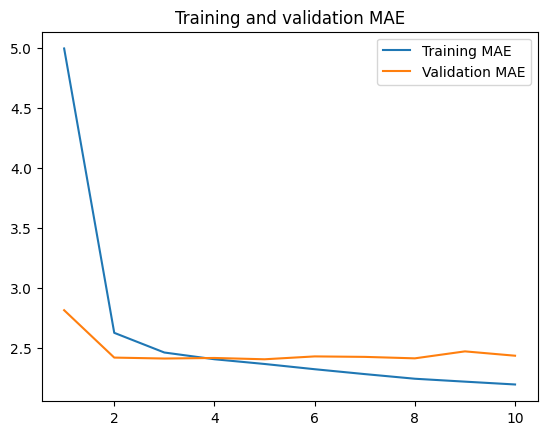

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")  # it is possible to get down to ~2.55 like in the book!

405/405 [==============================] - 17s 38ms/step - loss: 11.0216 - mae: 2.5934
Test MAE: 2.59


Common-sense Baseline is 2.59

### Network 1 - Different epoch sizes:

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs) # ← our LSTM
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training with bactch:  5
Epoch 1/5
819/819 [==============================] - 50s 52ms/step - loss: 46.9556 - mae: 5.0149 - val_loss: 13.7441 - val_mae: 2.8036
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 49s 60ms/step - loss: 11.2608 - mae: 2.6067 - val_loss: 9.5240 - val_mae: 2.4124
Epoch 3/5
819/819 [==============================] - 50s 61ms/step - loss: 9.8831 - mae: 2.4575 - val_loss: 9.6834 - val_mae: 2.4243
Epoch 4/5
819/819 [==============================] - 43s 52ms/step - loss: 9.4532 - mae: 2.4018 - val_loss: 9.7383 - val_mae: 2.4185
Epoch 5/5
819/819 [==============================] - 42s 51ms/step - loss: 9.2283 - mae: 2.3712 - val_loss: 9.6697 - val_mae: 2.4151


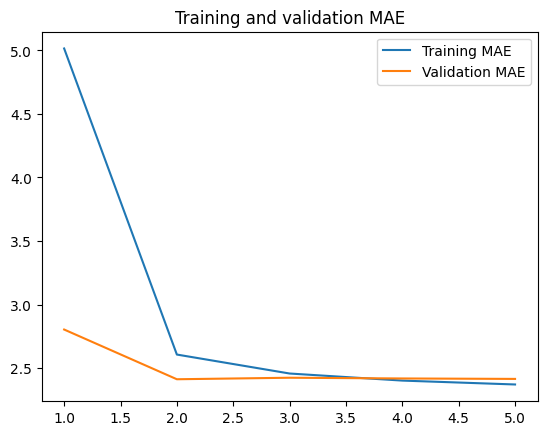


405/405 [==============================] - 14s 32ms/step - loss: 10.9375 - mae: 2.5974
Test MAE: 2.60

Training with bactch:  10
Epoch 1/10
819/819 [==============================] - 51s 60ms/step - loss: 9.8644 - mae: 2.4563 - val_loss: 9.7445 - val_mae: 2.4284
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 9.4566 - mae: 2.4030 - val_loss: 9.7735 - val_mae: 2.4284
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 9.1854 - mae: 2.3663 - val_loss: 9.8373 - val_mae: 2.4246
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 8.9878 - mae: 2.3378 - val_loss: 9.8495 - val_mae: 2.4252
Epoch 5/10
819/819 [==============================] - 42s 52ms/step - loss: 8.8205 - mae: 2.3148 - val_loss: 9.9840 - val_mae: 2.4422
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 8.6505 - mae: 2.2932 - val_loss: 10.1695 - val_mae: 2.4657
Epoch 7/10
819/819 [==============================] - 50s 61ms/st

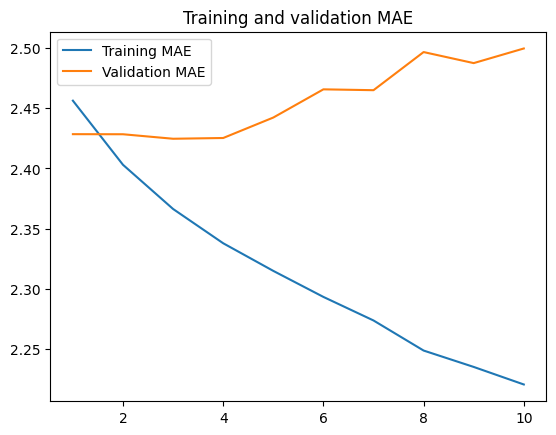


405/405 [==============================] - 14s 33ms/step - loss: 11.4711 - mae: 2.5875
Test MAE: 2.59

Training with bactch:  20
Epoch 1/20
819/819 [==============================] - 52s 62ms/step - loss: 9.4868 - mae: 2.4073 - val_loss: 9.6697 - val_mae: 2.4195
Epoch 2/20
819/819 [==============================] - 42s 51ms/step - loss: 9.2281 - mae: 2.3712 - val_loss: 9.9281 - val_mae: 2.4386
Epoch 3/20
819/819 [==============================] - 50s 61ms/step - loss: 9.0601 - mae: 2.3470 - val_loss: 9.9105 - val_mae: 2.4309
Epoch 4/20
819/819 [==============================] - 42s 52ms/step - loss: 8.8594 - mae: 2.3180 - val_loss: 9.6105 - val_mae: 2.4057
Epoch 5/20
819/819 [==============================] - 51s 62ms/step - loss: 8.6212 - mae: 2.2881 - val_loss: 10.1617 - val_mae: 2.4726
Epoch 6/20
819/819 [==============================] - 42s 51ms/step - loss: 8.4177 - mae: 2.2634 - val_loss: 10.2717 - val_mae: 2.4839
Epoch 7/20
819/819 [==============================] - 50s 60ms/s

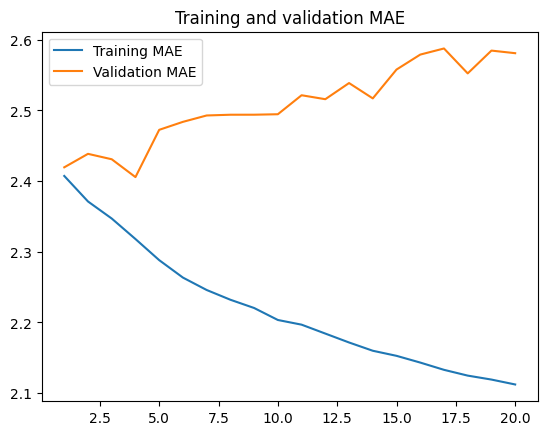


405/405 [==============================] - 13s 32ms/step - loss: 10.8156 - mae: 2.5831
Test MAE: 2.58

Training with bactch:  25
Epoch 1/25
819/819 [==============================] - 51s 60ms/step - loss: 8.6308 - mae: 2.2901 - val_loss: 10.2098 - val_mae: 2.4718
Epoch 2/25
819/819 [==============================] - 49s 60ms/step - loss: 8.4210 - mae: 2.2636 - val_loss: 10.1884 - val_mae: 2.4741
Epoch 3/25
819/819 [==============================] - 41s 49ms/step - loss: 8.2708 - mae: 2.2439 - val_loss: 10.3780 - val_mae: 2.4881
Epoch 4/25
819/819 [==============================] - 48s 59ms/step - loss: 8.1752 - mae: 2.2316 - val_loss: 10.2693 - val_mae: 2.4772
Epoch 5/25
819/819 [==============================] - 41s 49ms/step - loss: 8.0759 - mae: 2.2189 - val_loss: 10.5248 - val_mae: 2.5165
Epoch 6/25
819/819 [==============================] - 49s 60ms/step - loss: 7.9511 - mae: 2.2004 - val_loss: 10.2736 - val_mae: 2.4899
Epoch 7/25
819/819 [==============================] - 42s 50

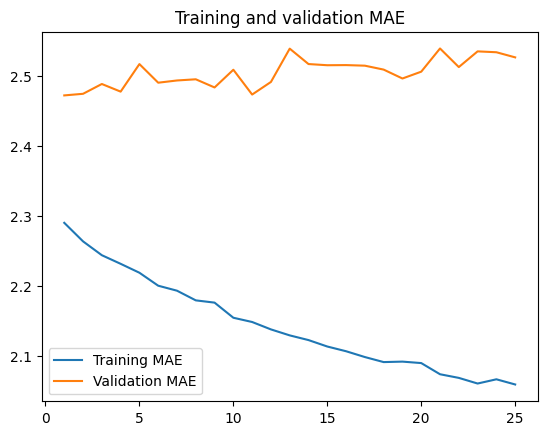


405/405 [==============================] - 14s 33ms/step - loss: 11.6169 - mae: 2.6501
Test MAE: 2.65

Training with bactch:  45
Epoch 1/45
819/819 [==============================] - 44s 51ms/step - loss: 8.2759 - mae: 2.2450 - val_loss: 10.4449 - val_mae: 2.5022
Epoch 2/45
819/819 [==============================] - 49s 60ms/step - loss: 8.1592 - mae: 2.2301 - val_loss: 10.4068 - val_mae: 2.4972
Epoch 3/45
819/819 [==============================] - 41s 50ms/step - loss: 8.0567 - mae: 2.2152 - val_loss: 10.6878 - val_mae: 2.5286
Epoch 4/45
819/819 [==============================] - 41s 50ms/step - loss: 7.9638 - mae: 2.2039 - val_loss: 10.5679 - val_mae: 2.5067
Epoch 5/45
819/819 [==============================] - 49s 59ms/step - loss: 7.8530 - mae: 2.1868 - val_loss: 10.6537 - val_mae: 2.5127
Epoch 6/45
819/819 [==============================] - 48s 58ms/step - loss: 7.7690 - mae: 2.1741 - val_loss: 10.4969 - val_mae: 2.5084
Epoch 7/45
819/819 [==============================] - 48s 59

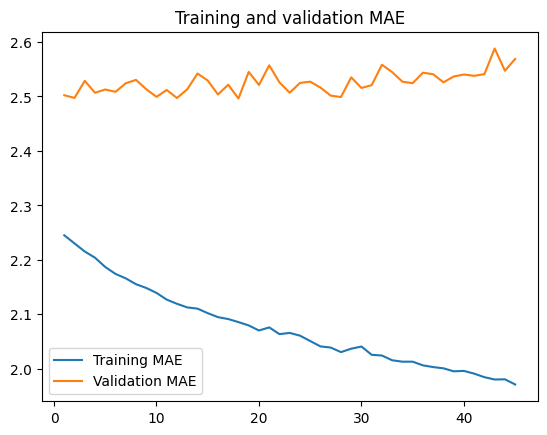


405/405 [==============================] - 14s 32ms/step - loss: 11.3648 - mae: 2.6479
Test MAE: 2.65

Training with bactch:  50
Epoch 1/50
819/819 [==============================] - 43s 50ms/step - loss: 8.0786 - mae: 2.2185 - val_loss: 10.2337 - val_mae: 2.4731
Epoch 2/50
819/819 [==============================] - 50s 60ms/step - loss: 7.9567 - mae: 2.2019 - val_loss: 10.5038 - val_mae: 2.5091
Epoch 3/50
819/819 [==============================] - 41s 49ms/step - loss: 7.8920 - mae: 2.1924 - val_loss: 10.3424 - val_mae: 2.4894
Epoch 4/50
819/819 [==============================] - 50s 60ms/step - loss: 7.7845 - mae: 2.1761 - val_loss: 10.6548 - val_mae: 2.5125
Epoch 5/50
819/819 [==============================] - 40s 49ms/step - loss: 7.7199 - mae: 2.1667 - val_loss: 10.7161 - val_mae: 2.5201
Epoch 6/50
819/819 [==============================] - 50s 61ms/step - loss: 7.6688 - mae: 2.1599 - val_loss: 10.6050 - val_mae: 2.5148
Epoch 7/50
819/819 [==============================] - 50s 61

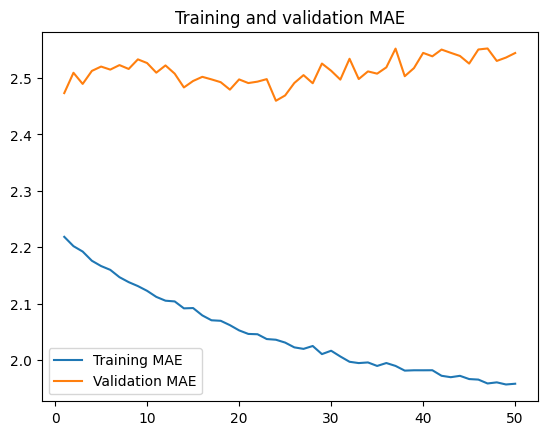


405/405 [==============================] - 13s 31ms/step - loss: 12.7436 - mae: 2.7274
Test MAE: 2.73



In [ ]:
for epoch_size in [5,10,20,25,45,50]:
    print("Training with epoch: ", epoch_size)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=epoch_size,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()


### Result of Network 1:
Common-sense baseline:  `2.59`

| Experiment number | Epoch number | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 5 | 2.60 | No |
| 2 | 10 | 2.59 | No |
| 3 | 20 | 2.58 | Yes (but only by 0.01) |
| 4 | 25 | 2.65 | No |
| 5 | 45 | 2.65 | No |
| 6 | 50 | 2.73 | No |

All experiment besides experiment 3 have failed to beat the common-sense baseline. Experiment 3 beat the common-sense baseline but only by 0.01. So I'll be using epoch 20 for the next networks.

## Network 2 - Different LSTM layer unit with 20 epoch

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 8)                 736       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training with LSTM Unit:  8
Epoch 1/20
819/819 [==============================] - 49s 52ms/step - loss: 69.3197 - mae: 6.4014 - val_loss: 33.6417 - val_mae: 4.3095
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 39s 47ms/step - loss: 22.3885 - mae: 3.5037 - val_loss: 12.9911 - val_mae: 2.7602
Epoch 3/20
819/819 [==============================] - 40s 49ms/step - loss: 12.4094 - mae: 2.7075 - val_loss: 10.2577 - val_mae: 2.5072
Epoch 4/20
819/819 [==============================] - 39s 48ms/step - loss: 10.4709 - mae: 2.5255 - val_loss: 9.9112 - val_mae: 2.4692
Epoch 5/20
819/819 [==============================] - 47s 58ms/step - loss: 10.1254 - mae: 2.4861 - val_loss: 9.8688 - val_mae: 2.4573
Epoch 6/20
819/819 [==============================] - 47s 57ms/step - loss: 9.9171 - mae: 2.4608 - val_loss: 9.7495 - val_mae: 2.4451
Epoch 7/20
819/819 [==============================] - 39s 47ms/step - loss: 9.7401 - mae: 2.4373 - val_loss: 9.7754 - val_mae: 2.4394
Epoch 8/20
819/819 [==============================] - 39s 48ms/step - loss: 9.6114 - mae: 2.4195 - val_loss: 9.8909 - val_mae: 2.4510
Epoch 9/20
819/819 [==============================] - 40s 48ms/step

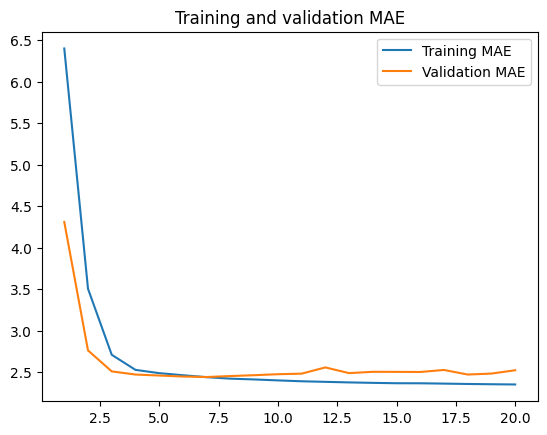


405/405 [==============================] - 13s 31ms/step - loss: 10.7248 - mae: 2.5635
Test MAE: 2.56

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 24)                3744      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 3769 (14.72 KB)
Trainable params: 3769 (14.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training with LSTM Unit:  24
Epoch 1/20
819/819 [==============================] - 51s 60ms/step - loss: 30.3947 - mae: 3.9464 - val_loss: 9.8645 - val_mae: 2.4278
Epoch 2/20
819/819 [===

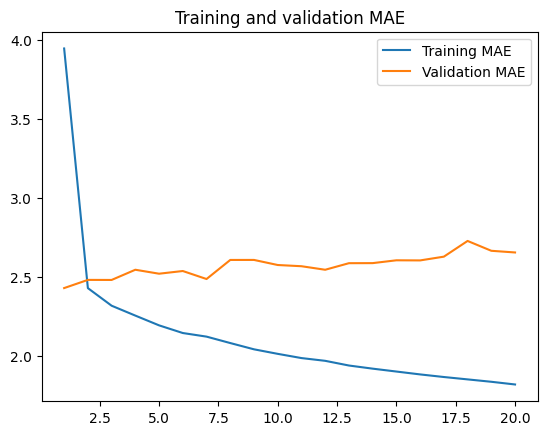


405/405 [==============================] - 12s 29ms/step - loss: 11.3903 - mae: 2.6272
Test MAE: 2.63

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                6016      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training with LSTM Unit:  32
Epoch 1/20
819/819 [==============================] - 41s 47ms/step - loss: 21.6305 - mae: 3.3426 - val_loss: 9.6066 - val_mae: 2.4035
Epoch 2/20
819/819 [===

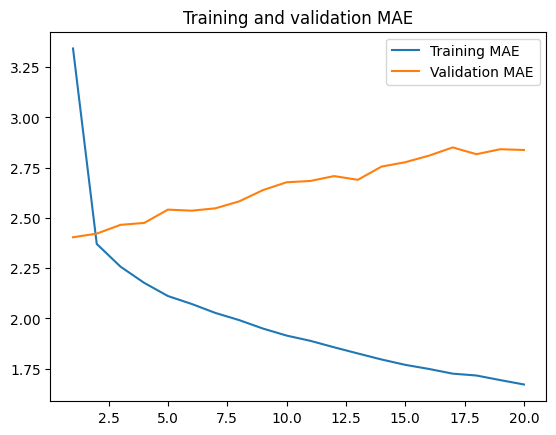


405/405 [==============================] - 13s 31ms/step - loss: 11.1141 - mae: 2.6058
Test MAE: 2.61

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20289 (79.25 KB)
Trainable params: 20289 (79.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training with LSTM Unit:  64
Epoch 1/20
819/819 [==============================] - 51s 60ms/step - loss: 14.5362 - mae: 2.8059 - val_loss: 9.8915 - val_mae: 2.4425
Epoch 2/20
819/819 [=

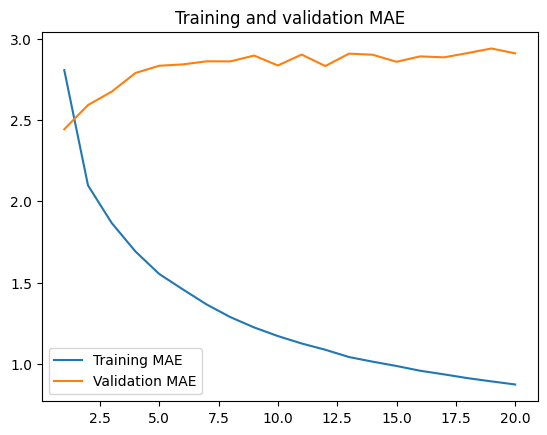


405/405 [==============================] - 12s 28ms/step - loss: 10.9236 - mae: 2.5924
Test MAE: 2.59

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 73345 (286.50 KB)
Trainable params: 73345 (286.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training with LSTM Unit:  128
Epoch 1/20
819/819 [==============================] - 42s 49ms/step - loss: 11.3455 - mae: 2.5328 - val_loss: 9.9886 - val_mae: 2.4698
Epoch 2/20
819/819

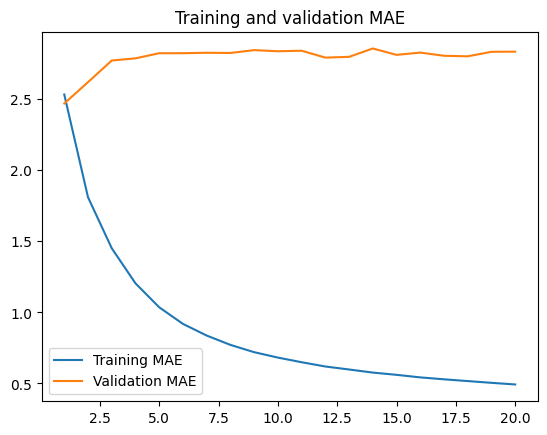


405/405 [==============================] - 19s 44ms/step - loss: 11.6900 - mae: 2.6786
Test MAE: 2.68

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 512)               1079296   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1079809 (4.12 MB)
Trainable params: 1079809 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training with LSTM Unit:  512
Epoch 1/20
819/819 [==============================] - 83s 99ms/step - loss: 11.0413 - mae: 2.5261 - val_loss: 10.1668 - val_mae: 2.4650
Epoch 2/20
819/81

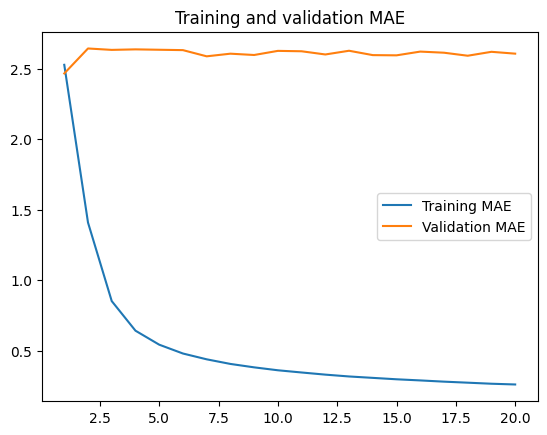


405/405 [==============================] - 15s 36ms/step - loss: 11.1696 - mae: 2.6407
Test MAE: 2.64



In [ ]:
for lstm_unit in [8,24,32,64,128,512]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(lstm_unit)(inputs) # ← our LSTM
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    model.summary()

    print("Training with LSTM Unit: ", lstm_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()


### Result of Network 2:
Common-sense baseline:  `2.59`

| Experiment number | Lstm layer number | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 8 | 2.56 | Yes (by 0.03) |
| 2 | 24 | 2.63 | No |
| 3 | 32 | 2.61 | No |
| 4 | 64 | 2.59 | No |
| 5 | 128 | 2.68 | No |
| 6 | 512 | 2.64 | No |

In this network all experiments expect eperiment 1 failed to beat the common-sense baseline experiment 1 beat the common-sense baseline by 0.03 overall the smaller lstm number the better result. I'll be using 8 Lstm layer number for the next networks

## Network 3 - Different dropout rates - with 20 epoch and 8 Lstm layer unit

Training with Dropout rate:  0.001
Epoch 1/20
819/819 [==============================] - 89s 106ms/step - loss: 65.3556 - mae: 6.2246 - val_loss: 31.6978 - val_mae: 4.1675


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
819/819 [==============================] - 88s 107ms/step - loss: 22.4354 - mae: 3.5156 - val_loss: 14.2611 - val_mae: 2.8340
Epoch 3/20
819/819 [==============================] - 87s 106ms/step - loss: 12.9892 - mae: 2.7564 - val_loss: 10.1106 - val_mae: 2.4935
Epoch 4/20
819/819 [==============================] - 87s 106ms/step - loss: 10.7429 - mae: 2.5592 - val_loss: 9.6466 - val_mae: 2.4396
Epoch 5/20
819/819 [==============================] - 93s 113ms/step - loss: 10.2412 - mae: 2.5006 - val_loss: 9.6737 - val_mae: 2.4350
Epoch 6/20
819/819 [==============================] - 88s 107ms/step - loss: 10.0227 - mae: 2.4710 - val_loss: 9.6341 - val_mae: 2.4246
Epoch 7/20
819/819 [==============================] - 88s 107ms/step - loss: 9.8344 - mae: 2.4441 - val_loss: 9.6167 - val_mae: 2.4236
Epoch 8/20
819/819 [==============================] - 88s 107ms/step - loss: 9.7125 - mae: 2.4277 - val_loss: 9.5488 - val_mae: 2.4169
Epoch 9/20
819/819 [============================

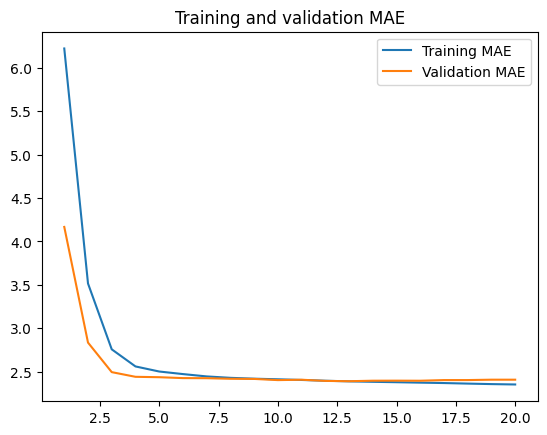


405/405 [==============================] - 16s 37ms/step - loss: 10.4437 - mae: 2.5410
Test MAE: 2.54

Training with Dropout rate:  0.01
Epoch 1/20
819/819 [==============================] - 95s 114ms/step - loss: 65.5422 - mae: 6.1932 - val_loss: 30.3582 - val_mae: 4.0717
Epoch 2/20
819/819 [==============================] - 87s 106ms/step - loss: 20.8669 - mae: 3.3859 - val_loss: 12.5852 - val_mae: 2.6758
Epoch 3/20
819/819 [==============================] - 88s 107ms/step - loss: 12.9782 - mae: 2.7426 - val_loss: 10.0244 - val_mae: 2.4593
Epoch 4/20
819/819 [==============================] - 87s 106ms/step - loss: 11.2851 - mae: 2.5999 - val_loss: 9.3916 - val_mae: 2.3885
Epoch 5/20
819/819 [==============================] - 88s 107ms/step - loss: 10.7146 - mae: 2.5407 - val_loss: 9.2892 - val_mae: 2.3695
Epoch 6/20
819/819 [==============================] - 87s 105ms/step - loss: 10.4660 - mae: 2.5159 - val_loss: 9.4253 - val_mae: 2.3856
Epoch 7/20
819/819 [=======================

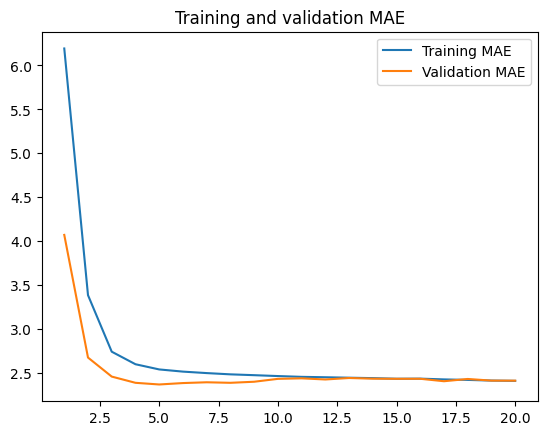


405/405 [==============================] - 15s 37ms/step - loss: 10.6409 - mae: 2.5482
Test MAE: 2.55

Training with Dropout rate:  0.11
Epoch 1/20
819/819 [==============================] - 92s 110ms/step - loss: 69.9456 - mae: 6.4498 - val_loss: 32.6075 - val_mae: 4.2481
Epoch 2/20
819/819 [==============================] - 88s 107ms/step - loss: 23.5734 - mae: 3.6147 - val_loss: 12.4902 - val_mae: 2.6803
Epoch 3/20
819/819 [==============================] - 86s 105ms/step - loss: 14.9025 - mae: 2.9597 - val_loss: 9.8506 - val_mae: 2.4410
Epoch 4/20
819/819 [==============================] - 87s 106ms/step - loss: 13.0871 - mae: 2.8093 - val_loss: 9.4868 - val_mae: 2.3999
Epoch 5/20
819/819 [==============================] - 95s 116ms/step - loss: 12.4819 - mae: 2.7463 - val_loss: 9.4220 - val_mae: 2.3906
Epoch 6/20
819/819 [==============================] - 88s 107ms/step - loss: 12.2997 - mae: 2.7262 - val_loss: 9.3058 - val_mae: 2.3817
Epoch 7/20
819/819 [========================

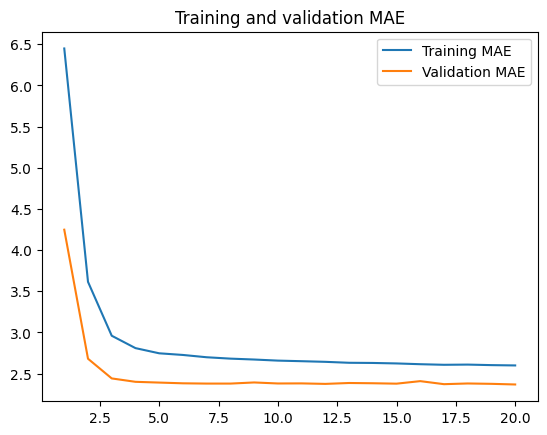


405/405 [==============================] - 15s 37ms/step - loss: 10.5176 - mae: 2.5394
Test MAE: 2.54

Training with Dropout rate:  0.25
Epoch 1/20
819/819 [==============================] - 88s 105ms/step - loss: 67.7557 - mae: 6.3391 - val_loss: 32.4157 - val_mae: 4.2108
Epoch 2/20
819/819 [==============================] - 87s 107ms/step - loss: 25.6864 - mae: 3.7886 - val_loss: 12.6914 - val_mae: 2.6990
Epoch 3/20
819/819 [==============================] - 87s 105ms/step - loss: 18.0773 - mae: 3.2569 - val_loss: 10.3455 - val_mae: 2.4963
Epoch 4/20
819/819 [==============================] - 86s 105ms/step - loss: 16.2070 - mae: 3.1131 - val_loss: 9.6248 - val_mae: 2.4198
Epoch 5/20
819/819 [==============================] - 87s 107ms/step - loss: 15.3397 - mae: 3.0281 - val_loss: 9.3302 - val_mae: 2.3827
Epoch 6/20
819/819 [==============================] - 86s 105ms/step - loss: 14.9657 - mae: 2.9919 - val_loss: 9.2355 - val_mae: 2.3735
Epoch 7/20
819/819 [=======================

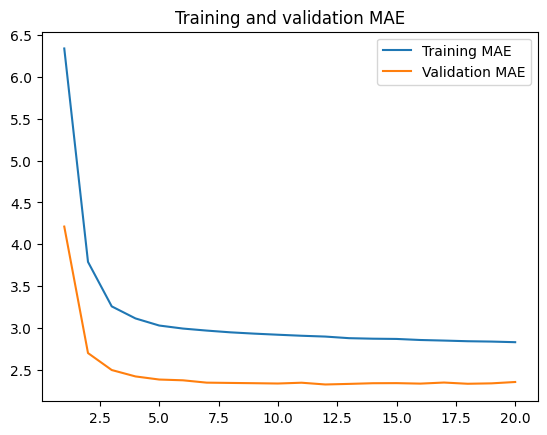


405/405 [==============================] - 15s 37ms/step - loss: 10.2556 - mae: 2.5047
Test MAE: 2.50

Training with Dropout rate:  0.5
Epoch 1/20
819/819 [==============================] - 90s 108ms/step - loss: 73.2927 - mae: 6.6209 - val_loss: 32.2994 - val_mae: 4.2137
Epoch 2/20
819/819 [==============================] - 89s 108ms/step - loss: 32.6593 - mae: 4.2956 - val_loss: 13.5993 - val_mae: 2.7786
Epoch 3/20
819/819 [==============================] - 88s 107ms/step - loss: 25.9342 - mae: 3.8580 - val_loss: 11.0120 - val_mae: 2.5625
Epoch 4/20
819/819 [==============================] - 87s 106ms/step - loss: 23.9468 - mae: 3.7224 - val_loss: 10.4968 - val_mae: 2.5228
Epoch 5/20
819/819 [==============================] - 88s 108ms/step - loss: 22.4685 - mae: 3.6110 - val_loss: 10.0159 - val_mae: 2.4763
Epoch 6/20
819/819 [==============================] - 88s 107ms/step - loss: 21.5242 - mae: 3.5323 - val_loss: 9.9375 - val_mae: 2.4662
Epoch 7/20
819/819 [======================

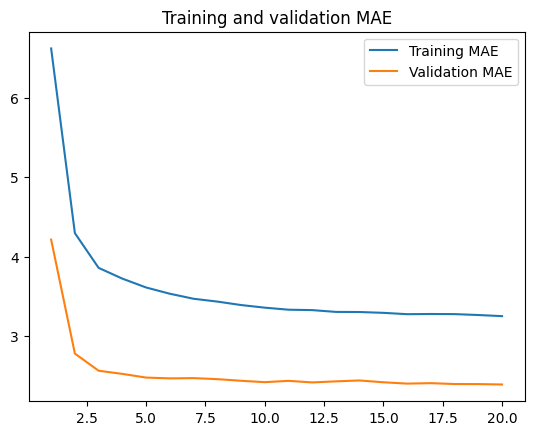


405/405 [==============================] - 15s 37ms/step - loss: 10.8516 - mae: 2.5780
Test MAE: 2.58

Training with Dropout rate:  0.75
Epoch 1/20
819/819 [==============================] - 89s 106ms/step - loss: 84.9530 - mae: 7.2026 - val_loss: 38.0886 - val_mae: 4.6407
Epoch 2/20
819/819 [==============================] - 93s 114ms/step - loss: 51.4932 - mae: 5.4096 - val_loss: 21.9400 - val_mae: 3.5932
Epoch 3/20
819/819 [==============================] - 88s 107ms/step - loss: 44.6620 - mae: 5.0339 - val_loss: 19.2319 - val_mae: 3.4323
Epoch 4/20
819/819 [==============================] - 88s 107ms/step - loss: 40.7719 - mae: 4.8049 - val_loss: 16.9645 - val_mae: 3.2238
Epoch 5/20
819/819 [==============================] - 88s 107ms/step - loss: 37.5290 - mae: 4.6021 - val_loss: 16.0330 - val_mae: 3.1353
Epoch 6/20
819/819 [==============================] - 88s 107ms/step - loss: 35.1014 - mae: 4.4573 - val_loss: 14.8683 - val_mae: 3.0206
Epoch 7/20
819/819 [====================

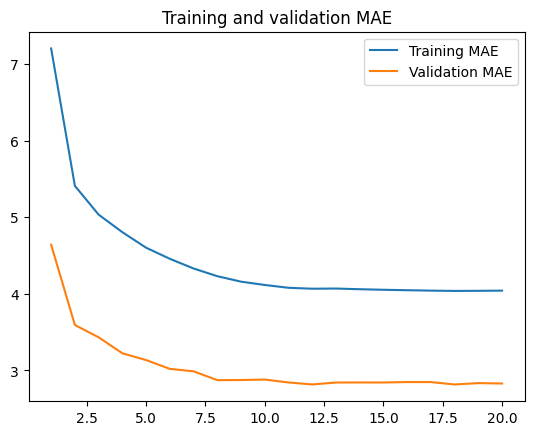


405/405 [==============================] - 16s 37ms/step - loss: 14.4446 - mae: 2.9824
Test MAE: 2.98



In [ ]:
for dropout_rate in [0.001,0.01,0.11,0.25,0.5,0.75]:
    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_dropout=dropout_rate)(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Dropout rate: ", dropout_rate)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()



### Result of Network 3:
Common-sense baseline:  `2.59`

| Experiment number | Dropout Rate | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 0.001 | 2.54 | Yes (by 0.05) |
| 2 | 0.01 | 2.55 | Yes (by 0.04)|
| 3 | 0.11 | 2.54 | Yes (by 0.05)|
| 4 | 0.25 | 2.50 | Yes (by 0.09)|
| 5 | 0.5 | 2.58 | Yes (by 0.01)|
| 6 | 0.75 | 2.98 | No |

All experiments expect experiment 6 have beat the common-sense baseline, experiment 4 was the best one with a dropout rate of 0.25 beating the common-sense baseline by 0.09 therefore I'll use dropout of 0.25 on the next networks. This was the best network so far as only experiment 6 failed.

### Network 4 Different regularizer rates - with 20 epoch, 8 Lstm layer unit and 0.25 dropout rate

Training with Regularizer rate:  0.005
Epoch 1/20
819/819 [==============================] - 322s 355ms/step - loss: 73.5669 - mae: 6.6099 - val_loss: 34.9089 - val_mae: 4.3762
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 288s 352ms/step - loss: 26.3442 - mae: 3.8188 - val_loss: 13.1135 - val_mae: 2.7178
Epoch 3/20
819/819 [==============================] - 281s 343ms/step - loss: 17.6533 - mae: 3.2111 - val_loss: 9.9347 - val_mae: 2.4339
Epoch 4/20
819/819 [==============================] - 285s 347ms/step - loss: 16.1756 - mae: 3.0942 - val_loss: 9.4861 - val_mae: 2.3805
Epoch 5/20
819/819 [==============================] - 296s 362ms/step - loss: 15.3949 - mae: 3.0269 - val_loss: 9.3439 - val_mae: 2.3671
Epoch 6/20
819/819 [==============================] - 292s 357ms/step - loss: 14.8696 - mae: 2.9788 - val_loss: 9.2205 - val_mae: 2.3494
Epoch 7/20
819/819 [==============================] - 291s 355ms/step - loss: 14.5403 - mae: 2.9430 - val_loss: 9.0616 - val_mae: 2.3383
Epoch 8/20
819/819 [==============================] - 293s 357ms/step - loss: 14.2006 - mae: 2.9121 - val_loss: 9.2033 - val_mae: 2.3512
Epoch 9/20
819/819 [==============================]

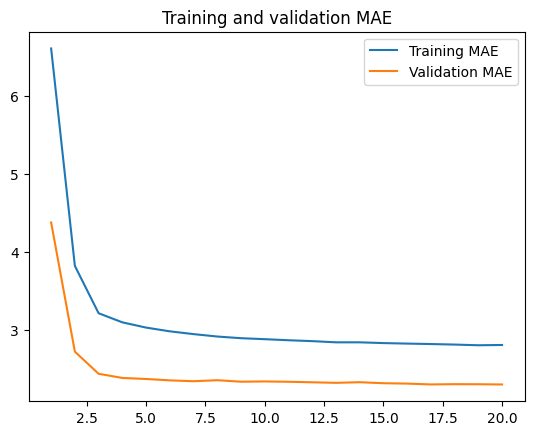


405/405 [==============================] - 30s 73ms/step - loss: 10.2495 - mae: 2.5073
Test MAE: 2.51



In [ ]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_regularizer=tf.keras.regularizers.L2(0.005),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Regularizer rate: ", 0.005)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()



Training with Regularizer rate:  0.02
Epoch 1/20
819/819 [==============================] - 160s 192ms/step - loss: 75.9725 - mae: 6.7475 - val_loss: 36.5296 - val_mae: 4.4753


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
819/819 [==============================] - 130s 158ms/step - loss: 27.7357 - mae: 3.9114 - val_loss: 13.5243 - val_mae: 2.7527
Epoch 3/20
819/819 [==============================] - 152s 185ms/step - loss: 18.5223 - mae: 3.2705 - val_loss: 10.5212 - val_mae: 2.4912
Epoch 4/20
819/819 [==============================] - 132s 161ms/step - loss: 16.1397 - mae: 3.0895 - val_loss: 9.4774 - val_mae: 2.3765
Epoch 5/20
819/819 [==============================] - 151s 185ms/step - loss: 15.2127 - mae: 3.0060 - val_loss: 9.6069 - val_mae: 2.3914
Epoch 6/20
819/819 [==============================] - 131s 160ms/step - loss: 14.7120 - mae: 2.9588 - val_loss: 9.3935 - val_mae: 2.3690
Epoch 7/20
819/819 [==============================] - 132s 161ms/step - loss: 14.4063 - mae: 2.9278 - val_loss: 9.6422 - val_mae: 2.3968
Epoch 8/20
819/819 [==============================] - 133s 161ms/step - loss: 14.1216 - mae: 2.9013 - val_loss: 9.2560 - val_mae: 2.3504
Epoch 9/20
819/819 [===================

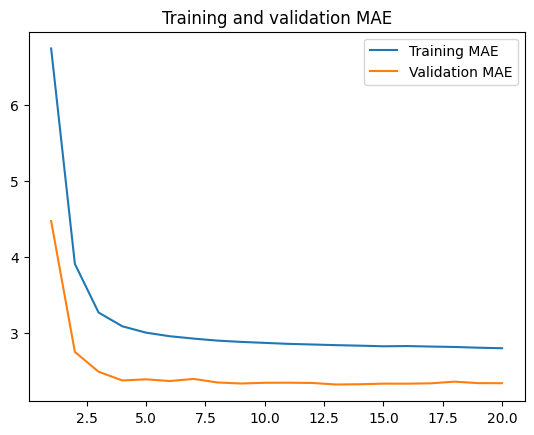


405/405 [==============================] - 23s 56ms/step - loss: 10.1055 - mae: 2.4800
Test MAE: 2.48



In [ ]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_regularizer=tf.keras.regularizers.L2(0.02),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Regularizer rate: ", 0.02)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with Regularizer rate:  0.15
Epoch 1/20
819/819 [==============================] - 138s 163ms/step - loss: 67.7283 - mae: 6.2543 - val_loss: 31.3402 - val_mae: 4.0935
Epoch 2/20
819/819 [==============================] - 132s 161ms/step - loss: 25.3068 - mae: 3.7388 - val_loss: 12.7572 - val_mae: 2.6998
Epoch 3/20
819/819 [==============================] - 153s 186ms/step - loss: 17.4003 - mae: 3.1901 - val_loss: 10.1280 - val_mae: 2.4444
Epoch 4/20
819/819 [==============================] - 130s 158ms/step - loss: 15.7274 - mae: 3.0519 - val_loss: 9.6413 - val_mae: 2.3999
Epoch 5/20
819/819 [==============================] - 135s 164ms/step - loss: 15.0045 - mae: 2.9866 - val_loss: 9.2623 - val_mae: 2.3524
Epoch 6/20
819/819 [==============================] - 130s 159ms/step - loss: 14.6610 - mae: 2.9546 - val_loss: 9.1728 - val_mae: 2.3448
Epoch 7/20
819/819 [==============================] - 152s 185ms/step - loss: 14.5028 - mae: 2.9412 - val_loss: 9.1408 - val_mae: 2.3412


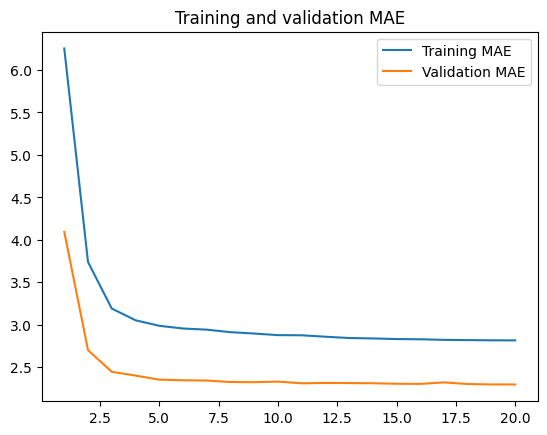


405/405 [==============================] - 21s 51ms/step - loss: 9.8455 - mae: 2.4494
Test MAE: 2.45



In [ ]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Regularizer rate: ", 0.15)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with Regularizer rate:  0.33
Epoch 1/20
819/819 [==============================] - 142s 170ms/step - loss: 77.7549 - mae: 6.7456 - val_loss: 39.1112 - val_mae: 4.6216
Epoch 2/20
819/819 [==============================] - 132s 161ms/step - loss: 28.5501 - mae: 3.9547 - val_loss: 14.0195 - val_mae: 2.7981
Epoch 3/20
819/819 [==============================] - 154s 188ms/step - loss: 18.0305 - mae: 3.2257 - val_loss: 10.2230 - val_mae: 2.4535
Epoch 4/20
819/819 [==============================] - 133s 162ms/step - loss: 15.8748 - mae: 3.0618 - val_loss: 9.6950 - val_mae: 2.4083
Epoch 5/20
819/819 [==============================] - 152s 185ms/step - loss: 15.2588 - mae: 3.0132 - val_loss: 9.4485 - val_mae: 2.3831
Epoch 6/20
819/819 [==============================] - 151s 184ms/step - loss: 14.7404 - mae: 2.9663 - val_loss: 9.4032 - val_mae: 2.3827
Epoch 7/20
819/819 [==============================] - 153s 186ms/step - loss: 14.3759 - mae: 2.9318 - val_loss: 9.3351 - val_mae: 2.3765


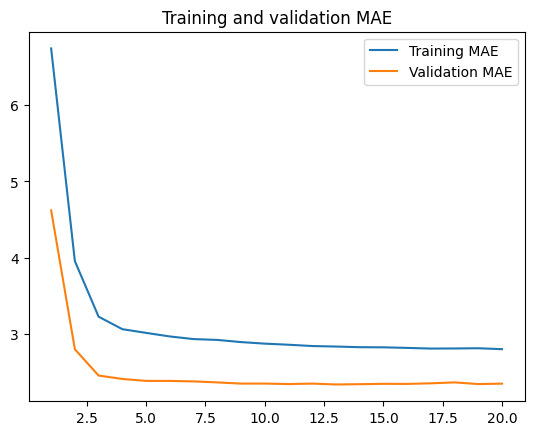


405/405 [==============================] - 26s 63ms/step - loss: 10.3753 - mae: 2.5176
Test MAE: 2.52



In [ ]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_regularizer=tf.keras.regularizers.L2(0.33),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Regularizer rate: ", 0.33)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with Regularizer rate:  0.55
Epoch 1/20
819/819 [==============================] - 156s 187ms/step - loss: 79.3058 - mae: 6.8345 - val_loss: 39.5298 - val_mae: 4.6514
Epoch 2/20
819/819 [==============================] - 152s 185ms/step - loss: 28.1997 - mae: 3.9261 - val_loss: 13.9101 - val_mae: 2.7830
Epoch 3/20
819/819 [==============================] - 137s 166ms/step - loss: 17.8367 - mae: 3.2150 - val_loss: 10.3456 - val_mae: 2.4635
Epoch 4/20
819/819 [==============================] - 132s 161ms/step - loss: 15.6505 - mae: 3.0449 - val_loss: 9.6272 - val_mae: 2.4013
Epoch 5/20
819/819 [==============================] - 132s 161ms/step - loss: 14.9347 - mae: 2.9822 - val_loss: 9.4042 - val_mae: 2.3857
Epoch 6/20
819/819 [==============================] - 135s 165ms/step - loss: 14.5753 - mae: 2.9487 - val_loss: 9.2889 - val_mae: 2.3766
Epoch 7/20
819/819 [==============================] - 155s 189ms/step - loss: 14.1976 - mae: 2.9161 - val_loss: 9.2017 - val_mae: 2.3641


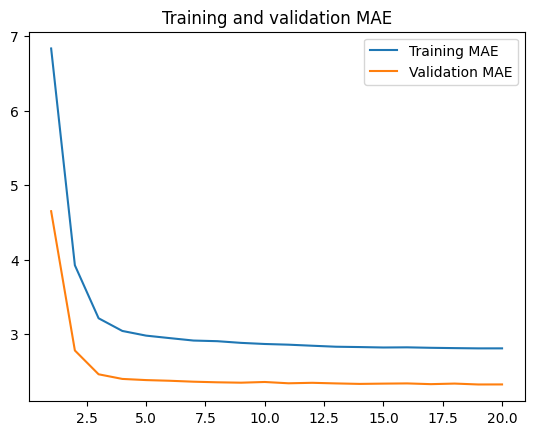


405/405 [==============================] - 24s 58ms/step - loss: 10.2143 - mae: 2.4931
Test MAE: 2.49



In [ ]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_regularizer=tf.keras.regularizers.L2(0.55),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Regularizer rate: ", 0.55)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with Regularizer rate:  0.88
Epoch 1/20
819/819 [==============================] - 284s 340ms/step - loss: 71.9519 - mae: 6.4119 - val_loss: 32.5111 - val_mae: 4.1915
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 296s 361ms/step - loss: 25.5577 - mae: 3.7605 - val_loss: 12.8740 - val_mae: 2.6927
Epoch 3/20
819/819 [==============================] - 281s 343ms/step - loss: 17.6746 - mae: 3.2054 - val_loss: 10.0000 - val_mae: 2.4300
Epoch 4/20
819/819 [==============================] - 277s 338ms/step - loss: 15.7885 - mae: 3.0601 - val_loss: 9.3371 - val_mae: 2.3708
Epoch 5/20
819/819 [==============================] - 283s 346ms/step - loss: 15.0663 - mae: 2.9971 - val_loss: 9.3043 - val_mae: 2.3647
Epoch 6/20
819/819 [==============================] - 296s 361ms/step - loss: 14.6061 - mae: 2.9585 - val_loss: 9.1501 - val_mae: 2.3478
Epoch 7/20
819/819 [==============================] - 289s 352ms/step - loss: 14.2590 - mae: 2.9227 - val_loss: 9.1771 - val_mae: 2.3525
Epoch 8/20
819/819 [==============================] - 286s 349ms/step - loss: 14.1283 - mae: 2.9086 - val_loss: 9.2109 - val_mae: 2.3544
Epoch 9/20
819/819 [==============================

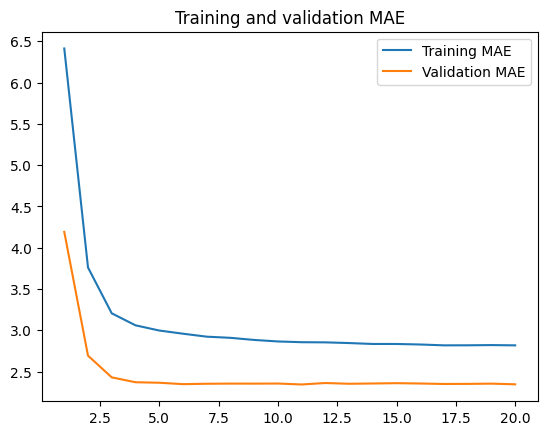


405/405 [==============================] - 27s 66ms/step - loss: 10.1464 - mae: 2.4734
Test MAE: 2.47



In [ ]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.LSTM(8, recurrent_regularizer=tf.keras.regularizers.L2(0.88),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with Regularizer rate: ", 0.88)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

### Result of Network 4:
Common-sense baseline:  `2.59`

| Experiment number | Regularizer Rate | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 0.005| 2.51 | Yes (by 0.08)|
| 2 | 0.02 | 2.48 | Yes (by 0.11)|
| 3 | 0.15 | 2.45 | Yes (by 0.14)|
| 4 | 0.33 | 2.52 | Yes (by 0.07)|
| 5 | 0.55 | 2.49 | Yes (by 0.10)|
| 6 | 0.88 | 2.47 | Yes (by 0.12)|

In network 4 I couldn't use loops as it would take too long to run the cell and I would run out of time an average of 1hr 30 for each cell. But all the experiments beat the common-sense baseline the best experiment was experiment 3 with regularizer rate of 0.15 which produced a result of 2.45 and the worst experiment was experiment 4 with regularizer rate of 0.33 with a result of 2.52

## NETWORK 5 - 2nd Layer Added Wih Mostly Different Stacked GRU Model Units To 1st Layer - with 20 epoch, 8 GRU layer unit (1st layer), 0.25 dropout rate and regularizer rate of 0.15

Training with GRU Unit:  8
Epoch 1/20
819/819 [==============================] - 150s 179ms/step - loss: 68.3243 - mae: 6.3169 - val_loss: 32.7822 - val_mae: 4.1794
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 128s 156ms/step - loss: 24.0690 - mae: 3.6359 - val_loss: 12.8952 - val_mae: 2.6655
Epoch 3/20
819/819 [==============================] - 131s 159ms/step - loss: 16.4920 - mae: 3.1031 - val_loss: 9.9175 - val_mae: 2.4123
Epoch 4/20
819/819 [==============================] - 151s 184ms/step - loss: 15.2690 - mae: 3.0087 - val_loss: 9.3825 - val_mae: 2.3672
Epoch 5/20
819/819 [==============================] - 148s 180ms/step - loss: 14.6664 - mae: 2.9535 - val_loss: 9.4095 - val_mae: 2.3776
Epoch 6/20
819/819 [==============================] - 148s 180ms/step - loss: 14.3528 - mae: 2.9254 - val_loss: 9.1817 - val_mae: 2.3513
Epoch 7/20
819/819 [==============================] - 148s 180ms/step - loss: 14.0149 - mae: 2.8928 - val_loss: 9.1393 - val_mae: 2.3487
Epoch 8/20
819/819 [==============================] - 131s 159ms/step - loss: 13.8102 - mae: 2.8719 - val_loss: 9.0940 - val_mae: 2.3418
Epoch 9/20
819/819 [==============================]

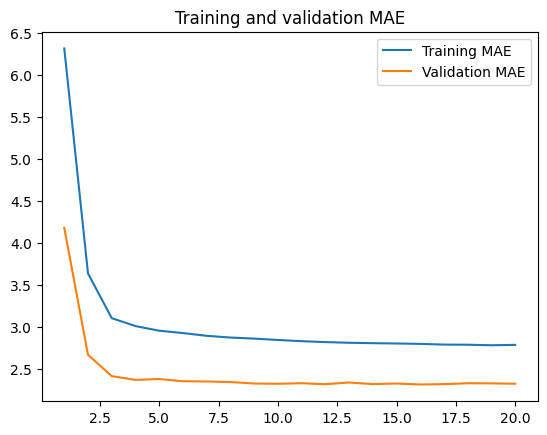


405/405 [==============================] - 24s 58ms/step - loss: 10.1967 - mae: 2.4833
Test MAE: 2.48

Training with GRU Unit:  24
Epoch 1/20
819/819 [==============================] - 183s 220ms/step - loss: 34.9747 - mae: 4.1989 - val_loss: 10.1005 - val_mae: 2.4222
Epoch 2/20
819/819 [==============================] - 163s 199ms/step - loss: 12.9683 - mae: 2.7981 - val_loss: 9.1917 - val_mae: 2.3468
Epoch 3/20
819/819 [==============================] - 163s 199ms/step - loss: 12.3836 - mae: 2.7374 - val_loss: 8.9886 - val_mae: 2.3213
Epoch 4/20
819/819 [==============================] - 163s 198ms/step - loss: 12.0861 - mae: 2.7008 - val_loss: 8.9499 - val_mae: 2.3162
Epoch 5/20
819/819 [==============================] - 176s 214ms/step - loss: 11.9010 - mae: 2.6820 - val_loss: 8.8802 - val_mae: 2.3082
Epoch 6/20
819/819 [==============================] - 180s 219ms/step - loss: 11.7738 - mae: 2.6653 - val_loss: 8.9383 - val_mae: 2.3104
Epoch 7/20
819/819 [=========================

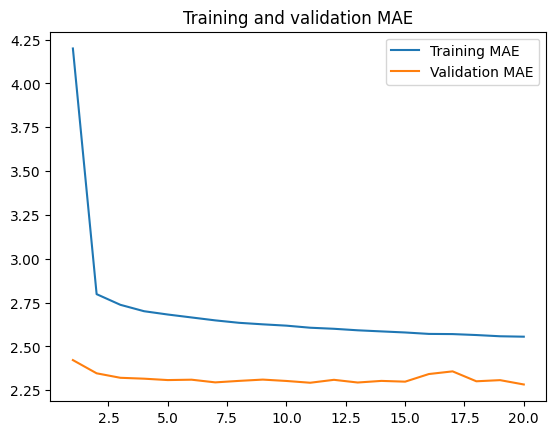


405/405 [==============================] - 28s 68ms/step - loss: 10.2920 - mae: 2.4860
Test MAE: 2.49

Training with GRU Unit:  32
Epoch 1/20
819/819 [==============================] - 198s 238ms/step - loss: 27.5852 - mae: 3.7098 - val_loss: 9.8972 - val_mae: 2.4281
Epoch 2/20
819/819 [==============================] - 198s 242ms/step - loss: 12.2126 - mae: 2.7147 - val_loss: 9.2165 - val_mae: 2.3540
Epoch 3/20
819/819 [==============================] - 197s 240ms/step - loss: 11.8381 - mae: 2.6745 - val_loss: 8.9245 - val_mae: 2.3076
Epoch 4/20
819/819 [==============================] - 195s 238ms/step - loss: 11.6590 - mae: 2.6539 - val_loss: 9.0891 - val_mae: 2.3332
Epoch 5/20
819/819 [==============================] - 194s 237ms/step - loss: 11.4945 - mae: 2.6333 - val_loss: 8.9228 - val_mae: 2.3077
Epoch 6/20
819/819 [==============================] - 179s 218ms/step - loss: 11.3845 - mae: 2.6209 - val_loss: 8.9210 - val_mae: 2.3114
Epoch 7/20
819/819 [==========================

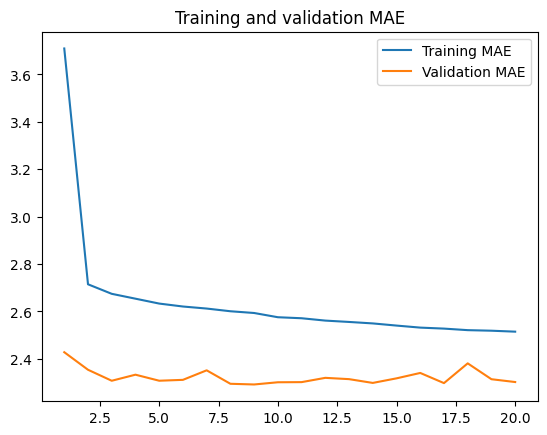


405/405 [==============================] - 30s 73ms/step - loss: 10.1734 - mae: 2.4795
Test MAE: 2.48

Training with GRU Unit:  64
Epoch 1/20
819/819 [==============================] - 300s 363ms/step - loss: 19.1021 - mae: 3.1100 - val_loss: 9.4598 - val_mae: 2.3639
Epoch 2/20
819/819 [==============================] - 300s 366ms/step - loss: 11.4089 - mae: 2.6196 - val_loss: 9.0617 - val_mae: 2.3259
Epoch 3/20
819/819 [==============================] - 296s 362ms/step - loss: 11.0784 - mae: 2.5848 - val_loss: 9.1948 - val_mae: 2.3494
Epoch 4/20
819/819 [==============================] - 302s 368ms/step - loss: 10.8844 - mae: 2.5620 - val_loss: 9.4181 - val_mae: 2.3722
Epoch 5/20
819/819 [==============================] - 301s 368ms/step - loss: 10.7255 - mae: 2.5407 - val_loss: 8.7389 - val_mae: 2.2736
Epoch 6/20
819/819 [==============================] - 300s 366ms/step - loss: 10.6053 - mae: 2.5241 - val_loss: 8.8783 - val_mae: 2.2907
Epoch 7/20
819/819 [==========================

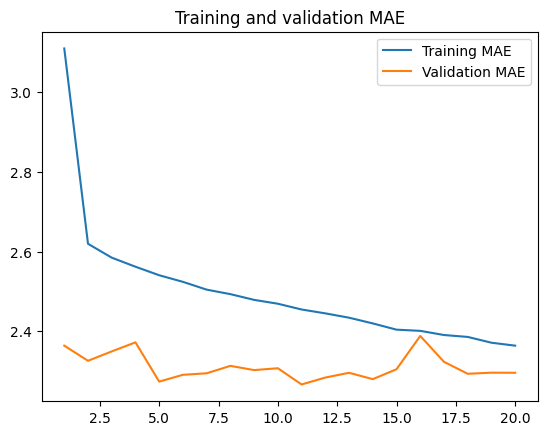


405/405 [==============================] - 41s 99ms/step - loss: 10.1228 - mae: 2.4663
Test MAE: 2.47

Training with GRU Unit:  128
Epoch 1/20
819/819 [==============================] - 703s 855ms/step - loss: 16.3441 - mae: 2.8528 - val_loss: 9.7490 - val_mae: 2.3968
Epoch 2/20
819/819 [==============================] - 696s 848ms/step - loss: 11.1383 - mae: 2.5796 - val_loss: 10.0729 - val_mae: 2.4755
Epoch 3/20
819/819 [==============================] - 692s 845ms/step - loss: 10.6940 - mae: 2.5341 - val_loss: 8.9558 - val_mae: 2.3014
Epoch 4/20
819/819 [==============================] - 688s 839ms/step - loss: 10.4417 - mae: 2.5010 - val_loss: 9.6693 - val_mae: 2.3992
Epoch 5/20
819/819 [==============================] - 688s 840ms/step - loss: 10.2353 - mae: 2.4727 - val_loss: 8.9332 - val_mae: 2.2890
Epoch 6/20
819/819 [==============================] - 694s 847ms/step - loss: 10.0838 - mae: 2.4526 - val_loss: 9.3186 - val_mae: 2.3466
Epoch 7/20
819/819 [========================

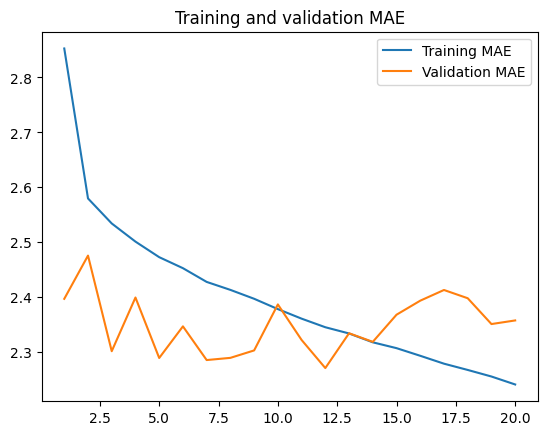


405/405 [==============================] - 99s 243ms/step - loss: 10.2954 - mae: 2.4765
Test MAE: 2.48

Training with GRU Unit:  512
Epoch 1/20
 10/819 [..............................] - ETA: 1:20:32 - loss: 124.8803 - mae: 6.6068

KeyboardInterrupt: ignored

In [ ]:
for Gru_unit in [8,24,32,64,128]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.GRU(8, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with GRU Unit: ", Gru_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

### Result of Network 5:
Common-sense baseline:  `2.59`

| Experiment number | GRU unit (2nd layer) | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 8| 2.48 | Yes (by 0.11)|
| 2 | 24 | 2.49 | Yes (by 0.10)|
| 3 | 32 | 2.48 | Yes (by 0.11)|
| 4 | 64 | 2.47 | Yes (by 0.12)|
| 5 | 128 | 2.48 | Yes (by 0.11)|

In Network 5 all the experiments beat the common-sense basedline the best result was experiment 4 with a Test MAE of 2.47 and the worst result was with experiment 2 with a Test MAEof 2.49. I was unable to do the last experiment eith 512 GRU unit as the ETA was 1hr 20 mins per epoch and this would be too long for 20 epochs this network did not beat the previous best network result of 2.45.

### NETWORK 6 - Same GRU Units On Each Layer (small units)  - with 20 epoch, 0.25 dropout rate and regularizer rate of 0.15

Training with GRU Unit:  1
Epoch 1/20
819/819 [==============================] - 74s 87ms/step - loss: 140.8903 - mae: 9.8059 - val_loss: 131.1204 - val_mae: 9.3774
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 72s 88ms/step - loss: 112.9898 - mae: 8.5515 - val_loss: 104.3273 - val_mae: 8.1516
Epoch 3/20
819/819 [==============================] - 71s 86ms/step - loss: 91.4304 - mae: 7.5207 - val_loss: 82.3523 - val_mae: 7.0918
Epoch 4/20
819/819 [==============================] - 72s 87ms/step - loss: 74.2100 - mae: 6.6374 - val_loss: 64.2603 - val_mae: 6.1395
Epoch 5/20
819/819 [==============================] - 74s 90ms/step - loss: 60.5204 - mae: 5.8888 - val_loss: 49.6889 - val_mae: 5.3091
Epoch 6/20
819/819 [==============================] - 75s 91ms/step - loss: 50.0642 - mae: 5.2736 - val_loss: 38.2682 - val_mae: 4.6028
Epoch 7/20
819/819 [==============================] - 75s 91ms/step - loss: 42.3416 - mae: 4.7792 - val_loss: 29.6510 - val_mae: 4.0239
Epoch 8/20
819/819 [==============================] - 75s 92ms/step - loss: 36.5661 - mae: 4.3982 - val_loss: 23.4290 - val_mae: 3.5823
Epoch 9/20
819/819 [==============================] - 79s

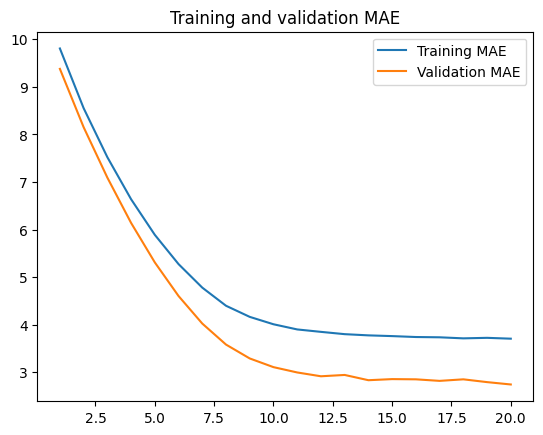


405/405 [==============================] - 16s 37ms/step - loss: 14.1460 - mae: 2.9111
Test MAE: 2.91

Training with GRU Unit:  5
Epoch 1/20
819/819 [==============================] - 86s 103ms/step - loss: 92.1227 - mae: 7.5245 - val_loss: 61.1913 - val_mae: 5.9136
Epoch 2/20
819/819 [==============================] - 84s 103ms/step - loss: 43.9210 - mae: 4.9047 - val_loss: 27.5141 - val_mae: 3.8143
Epoch 3/20
819/819 [==============================] - 82s 100ms/step - loss: 25.1724 - mae: 3.7296 - val_loss: 14.5276 - val_mae: 2.8083
Epoch 4/20
819/819 [==============================] - 84s 102ms/step - loss: 19.1698 - mae: 3.3135 - val_loss: 10.8240 - val_mae: 2.4946
Epoch 5/20
819/819 [==============================] - 89s 108ms/step - loss: 17.2457 - mae: 3.1721 - val_loss: 10.0267 - val_mae: 2.4337
Epoch 6/20
819/819 [==============================] - 83s 102ms/step - loss: 16.4310 - mae: 3.1080 - val_loss: 9.6188 - val_mae: 2.3963
Epoch 7/20
819/819 [============================

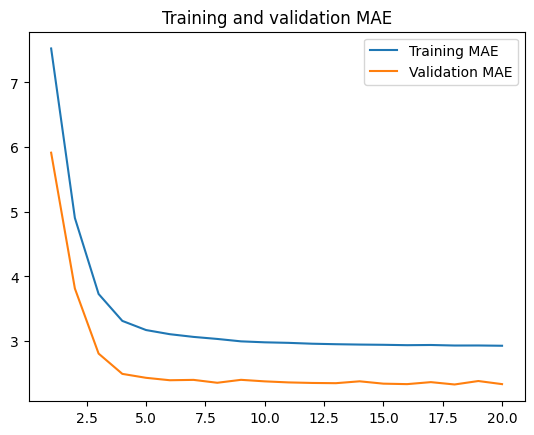


405/405 [==============================] - 17s 41ms/step - loss: 10.2373 - mae: 2.4886
Test MAE: 2.49

Training with GRU Unit:  8
Epoch 1/20
819/819 [==============================] - 89s 106ms/step - loss: 86.9041 - mae: 7.2320 - val_loss: 46.3038 - val_mae: 5.0557
Epoch 2/20
819/819 [==============================] - 91s 110ms/step - loss: 30.0975 - mae: 4.0525 - val_loss: 15.5279 - val_mae: 2.8940
Epoch 3/20
819/819 [==============================] - 92s 112ms/step - loss: 17.4048 - mae: 3.1812 - val_loss: 10.2912 - val_mae: 2.4453
Epoch 4/20
819/819 [==============================] - 87s 106ms/step - loss: 15.5052 - mae: 3.0301 - val_loss: 9.7713 - val_mae: 2.4090
Epoch 5/20
819/819 [==============================] - 86s 104ms/step - loss: 14.7076 - mae: 2.9618 - val_loss: 9.4360 - val_mae: 2.3868
Epoch 6/20
819/819 [==============================] - 88s 107ms/step - loss: 14.3664 - mae: 2.9285 - val_loss: 9.2263 - val_mae: 2.3545
Epoch 7/20
819/819 [==============================

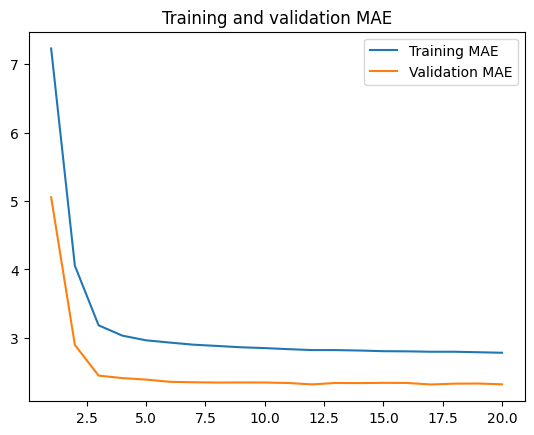


405/405 [==============================] - 16s 39ms/step - loss: 10.2246 - mae: 2.4845
Test MAE: 2.48



In [ ]:
for Gru_unit in [1,5,8]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with GRU Unit: ", Gru_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with GRU Unit:  15
Epoch 1/20
819/819 [==============================] - 106s 123ms/step - loss: 49.0909 - mae: 5.1231 - val_loss: 14.7368 - val_mae: 2.8219


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
819/819 [==============================] - 100s 122ms/step - loss: 14.8780 - mae: 2.9673 - val_loss: 9.6295 - val_mae: 2.3881
Epoch 3/20
819/819 [==============================] - 95s 116ms/step - loss: 13.3990 - mae: 2.8410 - val_loss: 9.1906 - val_mae: 2.3456
Epoch 4/20
819/819 [==============================] - 95s 116ms/step - loss: 13.0448 - mae: 2.8017 - val_loss: 9.2154 - val_mae: 2.3501
Epoch 5/20
819/819 [==============================] - 93s 113ms/step - loss: 12.7849 - mae: 2.7770 - val_loss: 9.0644 - val_mae: 2.3281
Epoch 6/20
819/819 [==============================] - 94s 115ms/step - loss: 12.5825 - mae: 2.7542 - val_loss: 8.9607 - val_mae: 2.3148
Epoch 7/20
819/819 [==============================] - 93s 113ms/step - loss: 12.4181 - mae: 2.7363 - val_loss: 9.1961 - val_mae: 2.3500
Epoch 8/20
819/819 [==============================] - 97s 118ms/step - loss: 12.2820 - mae: 2.7185 - val_loss: 8.9872 - val_mae: 2.3171
Epoch 9/20
819/819 [===========================

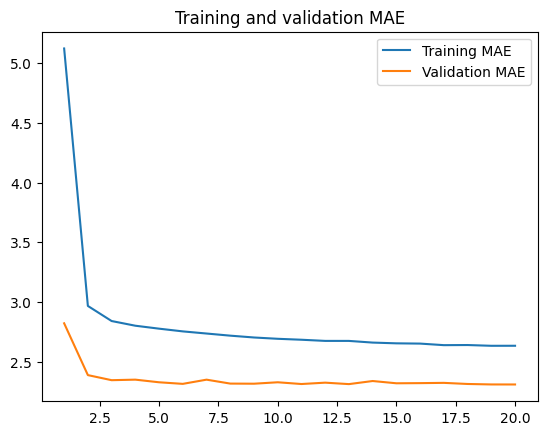


405/405 [==============================] - 19s 44ms/step - loss: 10.1690 - mae: 2.4810
Test MAE: 2.48

Training with GRU Unit:  25
Epoch 1/20
819/819 [==============================] - 116s 140ms/step - loss: 29.7128 - mae: 3.8947 - val_loss: 10.1272 - val_mae: 2.4429
Epoch 2/20
819/819 [==============================] - 111s 135ms/step - loss: 12.7108 - mae: 2.7709 - val_loss: 9.1500 - val_mae: 2.3482
Epoch 3/20
819/819 [==============================] - 112s 137ms/step - loss: 12.2650 - mae: 2.7228 - val_loss: 9.0239 - val_mae: 2.3252
Epoch 4/20
819/819 [==============================] - 112s 137ms/step - loss: 12.0155 - mae: 2.6947 - val_loss: 8.8604 - val_mae: 2.3039
Epoch 5/20
819/819 [==============================] - 109s 132ms/step - loss: 11.8283 - mae: 2.6726 - val_loss: 8.9426 - val_mae: 2.3154
Epoch 6/20
819/819 [==============================] - 113s 137ms/step - loss: 11.6432 - mae: 2.6511 - val_loss: 8.8877 - val_mae: 2.3028
Epoch 7/20
819/819 [=========================

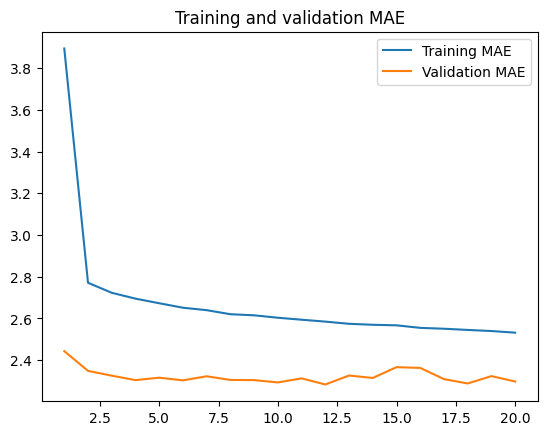


405/405 [==============================] - 19s 44ms/step - loss: 10.1104 - mae: 2.4722
Test MAE: 2.47

Training with GRU Unit:  35
Epoch 1/20
819/819 [==============================] - 127s 153ms/step - loss: 25.2153 - mae: 3.5707 - val_loss: 9.7155 - val_mae: 2.4007
Epoch 2/20
819/819 [==============================] - 125s 152ms/step - loss: 12.1051 - mae: 2.7037 - val_loss: 9.1294 - val_mae: 2.3386
Epoch 3/20
819/819 [==============================] - 125s 152ms/step - loss: 11.6975 - mae: 2.6605 - val_loss: 8.8827 - val_mae: 2.3025
Epoch 4/20
819/819 [==============================] - 123s 150ms/step - loss: 11.4755 - mae: 2.6331 - val_loss: 8.9109 - val_mae: 2.3088
Epoch 5/20
819/819 [==============================] - 126s 154ms/step - loss: 11.3306 - mae: 2.6173 - val_loss: 8.8860 - val_mae: 2.3006
Epoch 6/20
819/819 [==============================] - 124s 151ms/step - loss: 11.2359 - mae: 2.6035 - val_loss: 9.1922 - val_mae: 2.3454
Epoch 7/20
819/819 [==========================

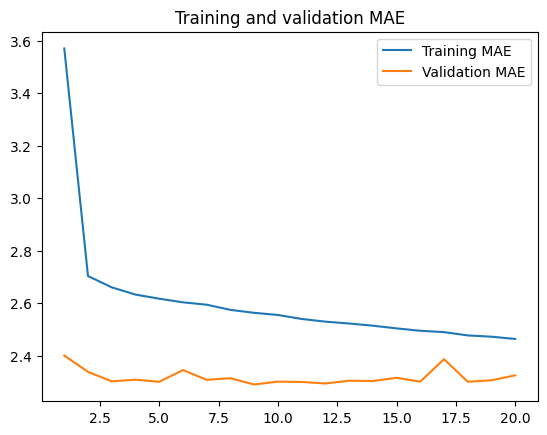


405/405 [==============================] - 21s 51ms/step - loss: 10.1229 - mae: 2.4656
Test MAE: 2.47



In [ ]:
for Gru_unit in [15,25,35]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with GRU Unit: ", Gru_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

### Result of Network 6:
Common-sense baseline:  `2.59`

| Experiment number | GRU layers unit | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 1| 2.91 | No|
| 2 | 5 | 2.49 | Yes (by 0.10)|
| 3 | 8 | 2.48 | Yes (by 0.11)|
| 4 | 15 | 2.48 | Yes (by 0.11)|
| 5 | 25 | 2.47 | Yes (by 0.12)|
| 6 | 35 | 2.47 | Yes (by 0.12)|

In Network 6 Experiment 1 was the only one to fail to beat the common-sense baseline. The best result in this network is experiment 5 and 6 with a Test MAE of 2.47 and the worst result was experiment 1 with a Test MAE of 2.91

### NETWORK 7 - Same GRU Units On Each Layer (Bigger units) - with 20 epoch, 0.25 dropout rate and regularizer rate of 0.15

Training with GRU Unit:  70
Epoch 1/20
819/819 [==============================] - 186s 225ms/step - loss: 18.4592 - mae: 3.0559 - val_loss: 9.6167 - val_mae: 2.3917
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 184s 224ms/step - loss: 11.3627 - mae: 2.6133 - val_loss: 9.2082 - val_mae: 2.3443
Epoch 3/20
819/819 [==============================] - 188s 229ms/step - loss: 10.9909 - mae: 2.5721 - val_loss: 9.0485 - val_mae: 2.3241
Epoch 4/20
819/819 [==============================] - 183s 224ms/step - loss: 10.7628 - mae: 2.5453 - val_loss: 9.0085 - val_mae: 2.3144
Epoch 5/20
819/819 [==============================] - 183s 223ms/step - loss: 10.5726 - mae: 2.5205 - val_loss: 8.7239 - val_mae: 2.2690
Epoch 6/20
819/819 [==============================] - 201s 246ms/step - loss: 10.4631 - mae: 2.5017 - val_loss: 8.9606 - val_mae: 2.3002
Epoch 7/20
819/819 [==============================] - 185s 225ms/step - loss: 10.3469 - mae: 2.4901 - val_loss: 9.5532 - val_mae: 2.3882
Epoch 8/20
819/819 [==============================] - 183s 223ms/step - loss: 10.2365 - mae: 2.4755 - val_loss: 8.8728 - val_mae: 2.2827
Epoch 9/20
819/819 [==============================] 

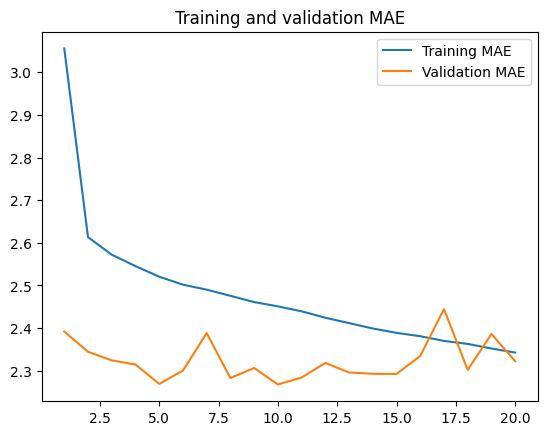


405/405 [==============================] - 26s 62ms/step - loss: 10.1219 - mae: 2.4636
Test MAE: 2.46

Training with GRU Unit:  100
Epoch 1/20
819/819 [==============================] - 301s 366ms/step - loss: 16.5947 - mae: 2.9061 - val_loss: 9.5167 - val_mae: 2.3635
Epoch 2/20
819/819 [==============================] - 300s 366ms/step - loss: 11.2350 - mae: 2.5937 - val_loss: 9.1222 - val_mae: 2.3283
Epoch 3/20
819/819 [==============================] - 301s 367ms/step - loss: 10.8067 - mae: 2.5495 - val_loss: 9.0036 - val_mae: 2.3087
Epoch 4/20
819/819 [==============================] - 299s 365ms/step - loss: 10.6028 - mae: 2.5231 - val_loss: 8.9044 - val_mae: 2.2927
Epoch 5/20
819/819 [==============================] - 299s 365ms/step - loss: 10.4171 - mae: 2.4993 - val_loss: 8.8147 - val_mae: 2.2780
Epoch 6/20
819/819 [==============================] - 301s 368ms/step - loss: 10.2741 - mae: 2.4784 - val_loss: 9.1366 - val_mae: 2.3253
Epoch 7/20
819/819 [=========================

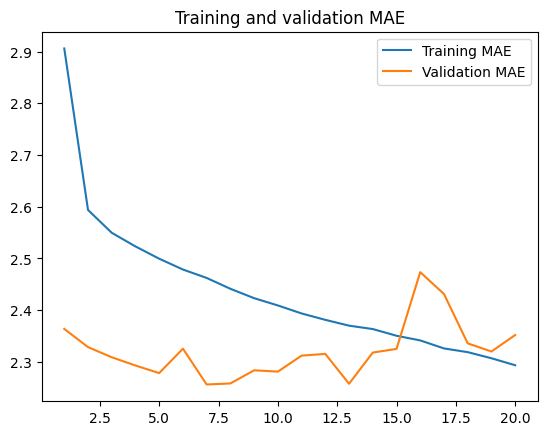


405/405 [==============================] - 42s 103ms/step - loss: 10.0163 - mae: 2.4372
Test MAE: 2.44

Training with GRU Unit:  150
Epoch 1/20
819/819 [==============================] - 458s 557ms/step - loss: 16.3147 - mae: 2.8367 - val_loss: 9.6749 - val_mae: 2.3673
Epoch 2/20
819/819 [==============================] - 456s 557ms/step - loss: 11.1679 - mae: 2.5814 - val_loss: 8.9784 - val_mae: 2.3057
Epoch 3/20
819/819 [==============================] - 482s 588ms/step - loss: 10.6567 - mae: 2.5308 - val_loss: 9.1220 - val_mae: 2.3201
Epoch 4/20
819/819 [==============================] - 455s 555ms/step - loss: 10.4192 - mae: 2.5008 - val_loss: 8.9381 - val_mae: 2.2974
Epoch 5/20
819/819 [==============================] - 458s 559ms/step - loss: 10.1485 - mae: 2.4616 - val_loss: 9.3580 - val_mae: 2.3460
Epoch 6/20
819/819 [==============================] - 456s 556ms/step - loss: 9.9407 - mae: 2.4338 - val_loss: 8.8660 - val_mae: 2.2713
Epoch 7/20
819/819 [=========================

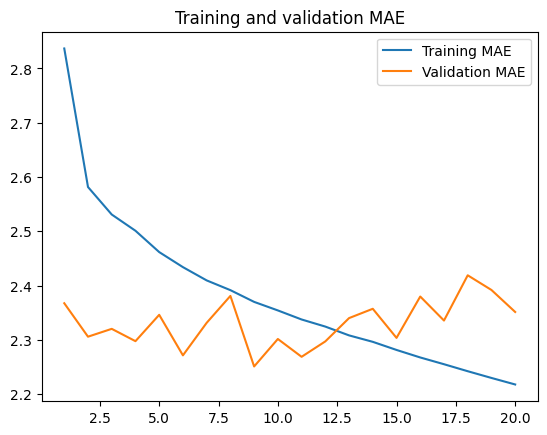


405/405 [==============================] - 57s 140ms/step - loss: 9.9881 - mae: 2.4238
Test MAE: 2.42



In [ ]:
for Gru_unit in [70,100,150]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with GRU Unit: ", Gru_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with GRU Unit:  175
Epoch 1/20
819/819 [==============================] - 520s 632ms/step - loss: 16.2340 - mae: 2.8203 - val_loss: 9.6628 - val_mae: 2.3677
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 517s 631ms/step - loss: 11.2090 - mae: 2.5819 - val_loss: 9.0950 - val_mae: 2.3247
Epoch 3/20
819/819 [==============================] - 518s 632ms/step - loss: 10.6243 - mae: 2.5258 - val_loss: 9.2547 - val_mae: 2.3511
Epoch 4/20
819/819 [==============================] - 517s 631ms/step - loss: 10.3639 - mae: 2.4919 - val_loss: 8.8286 - val_mae: 2.2846
Epoch 5/20
819/819 [==============================] - 518s 632ms/step - loss: 10.1946 - mae: 2.4698 - val_loss: 8.6654 - val_mae: 2.2476
Epoch 6/20
819/819 [==============================] - 521s 636ms/step - loss: 9.9357 - mae: 2.4343 - val_loss: 8.7767 - val_mae: 2.2551
Epoch 7/20
819/819 [==============================] - 518s 632ms/step - loss: 9.7703 - mae: 2.4108 - val_loss: 9.6719 - val_mae: 2.3861
Epoch 8/20
819/819 [==============================] - 518s 632ms/step - loss: 9.6157 - mae: 2.3912 - val_loss: 9.1457 - val_mae: 2.3021
Epoch 9/20
819/819 [==============================] - 5

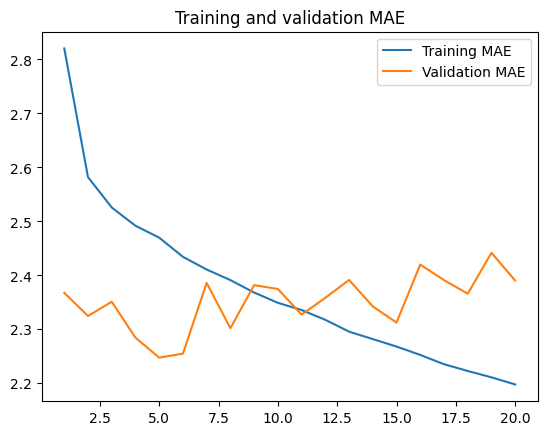


405/405 [==============================] - 63s 155ms/step - loss: 9.9798 - mae: 2.4384
Test MAE: 2.44

Training with GRU Unit:  200
Epoch 1/20
819/819 [==============================] - 608s 741ms/step - loss: 15.9356 - mae: 2.7936 - val_loss: 9.6039 - val_mae: 2.3570
Epoch 2/20
819/819 [==============================] - 605s 738ms/step - loss: 11.1962 - mae: 2.5792 - val_loss: 9.7818 - val_mae: 2.4258
Epoch 3/20
819/819 [==============================] - 606s 740ms/step - loss: 10.6333 - mae: 2.5242 - val_loss: 8.9150 - val_mae: 2.2914
Epoch 4/20
819/819 [==============================] - 607s 741ms/step - loss: 10.3026 - mae: 2.4807 - val_loss: 9.4246 - val_mae: 2.3540
Epoch 5/20
819/819 [==============================] - 608s 742ms/step - loss: 10.0269 - mae: 2.4466 - val_loss: 9.1852 - val_mae: 2.3065
Epoch 6/20
819/819 [==============================] - 605s 738ms/step - loss: 9.7835 - mae: 2.4128 - val_loss: 9.0906 - val_mae: 2.2972
Epoch 7/20
819/819 [==========================

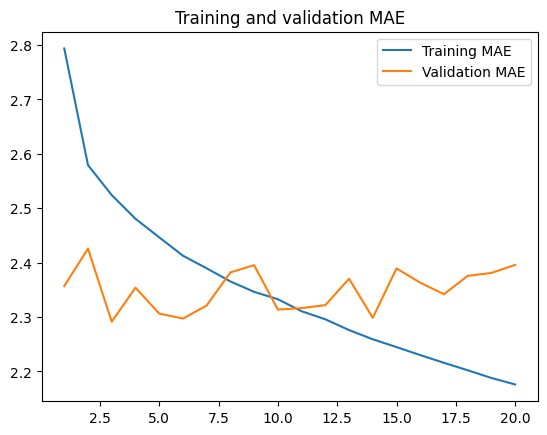


405/405 [==============================] - 72s 176ms/step - loss: 10.1940 - mae: 2.4623
Test MAE: 2.46

Training with GRU Unit:  250
Epoch 1/20
819/819 [==============================] - 812s 989ms/step - loss: 16.4380 - mae: 2.8040 - val_loss: 11.3115 - val_mae: 2.5853
Epoch 2/20
819/819 [==============================] - 824s 1s/step - loss: 11.2705 - mae: 2.5839 - val_loss: 9.6574 - val_mae: 2.4079
Epoch 3/20
819/819 [==============================] - 835s 1s/step - loss: 10.6232 - mae: 2.5219 - val_loss: 9.1637 - val_mae: 2.3242
Epoch 4/20
819/819 [==============================] - 833s 1s/step - loss: 10.3278 - mae: 2.4855 - val_loss: 8.8796 - val_mae: 2.2786
Epoch 5/20
819/819 [==============================] - 830s 1s/step - loss: 10.0688 - mae: 2.4507 - val_loss: 9.2387 - val_mae: 2.3265
Epoch 6/20
819/819 [==============================] - 828s 1s/step - loss: 9.8657 - mae: 2.4216 - val_loss: 9.5042 - val_mae: 2.3628
Epoch 7/20
819/819 [==============================] - 833s 

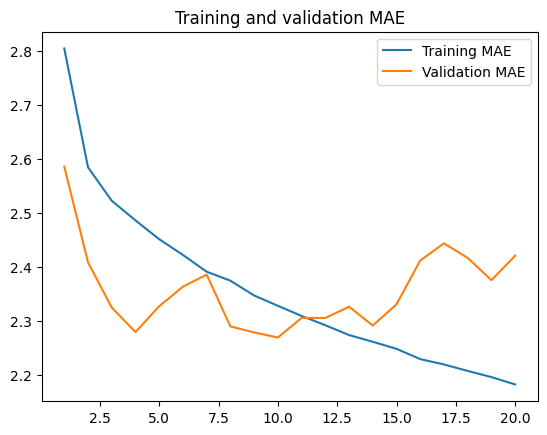


405/405 [==============================] - 97s 239ms/step - loss: 10.1424 - mae: 2.4543
Test MAE: 2.45



In [14]:
for Gru_unit in [175,200,250]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.GRU(Gru_unit, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    print("Training with GRU Unit: ", Gru_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_l2.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

### Result of Network 7:
Common-sense baseline:  `2.59`

| Experiment number | GRU layers unit | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 70   | 2.46 | Yes (by 0.13)|
| 2 | 100 | 2.44 | Yes (by 0.15)|
| 3 | 150 | 2.42 | Yes (by 0.17)|
| 4 | 175 | 2.44 | Yes (by 0.15)|
| 5 | 200 | 2.46 | Yes (by 0.13)|
| 6 | 250 | 2.45 | Yes (by 0.14)|

In network 7 all experiments beat the common-sense baseline the best experiment was experiment 3 with a Test MAE result of 2.42 and the worst experiment was experiment 1 and 5 with a Test MAE result of 2.46. Experiment 3 beats all previous network experiment results.

### Network 8 - Advanced Best Practices - RNN Reusable Layers- Different Lstm Units at Epoch 20

Training with LSTM Unit:  10
Epoch 1/20
819/819 [==============================] - 183s 218ms/step - loss: 137.8036 - mae: 9.6414 - val_loss: 144.0078 - val_mae: 9.8902
Epoch 2/20
819/819 [==============================] - 153s 186ms/step - loss: 136.9908 - mae: 9.5936 - val_loss: 143.9656 - val_mae: 9.8888
Epoch 3/20
819/819 [==============================] - 154s 187ms/step - loss: 136.9667 - mae: 9.5902 - val_loss: 143.9171 - val_mae: 9.8885
Epoch 4/20
819/819 [==============================] - 154s 188ms/step - loss: 136.9527 - mae: 9.5875 - val_loss: 143.8960 - val_mae: 9.8853
Epoch 5/20
819/819 [==============================] - 156s 190ms/step - loss: 136.9405 - mae: 9.5853 - val_loss: 143.9230 - val_mae: 9.8893
Epoch 6/20
819/819 [==============================] - 166s 202ms/step - loss: 136.9322 - mae: 9.5839 - val_loss: 143.9067 - val_mae: 9.8859
Epoch 7/20
819/819 [==============================] - 155s 188ms/step - loss: 136.9293 - mae: 9.5833 - val_loss: 143.9127 - val_mae

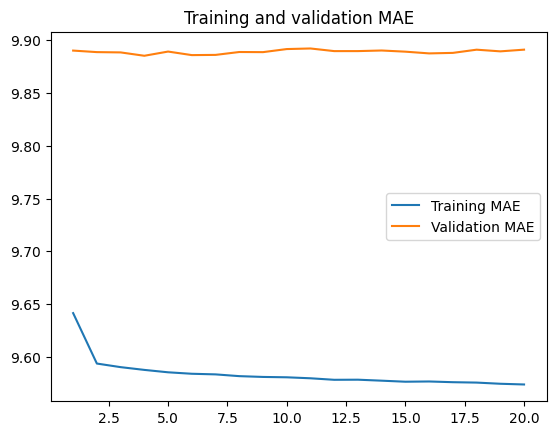


405/405 [==============================] - 33s 78ms/step - loss: 151.4289 - mae: 9.9272
Test MAE: 9.93

Training with LSTM Unit:  25
Epoch 1/20
819/819 [==============================] - 224s 268ms/step - loss: 137.2191 - mae: 9.6091 - val_loss: 143.9375 - val_mae: 9.8904
Epoch 2/20
819/819 [==============================] - 219s 267ms/step - loss: 136.9568 - mae: 9.5874 - val_loss: 143.9240 - val_mae: 9.8882
Epoch 3/20
819/819 [==============================] - 219s 267ms/step - loss: 136.9315 - mae: 9.5830 - val_loss: 143.9115 - val_mae: 9.8888
Epoch 4/20
819/819 [==============================] - 218s 266ms/step - loss: 136.9092 - mae: 9.5788 - val_loss: 143.9258 - val_mae: 9.8898
Epoch 5/20
819/819 [==============================] - 221s 270ms/step - loss: 136.9007 - mae: 9.5768 - val_loss: 143.9001 - val_mae: 9.8854
Epoch 6/20
819/819 [==============================] - 260s 318ms/step - loss: 136.8906 - mae: 9.5745 - val_loss: 143.9091 - val_mae: 9.8869
Epoch 7/20
819/819 [======

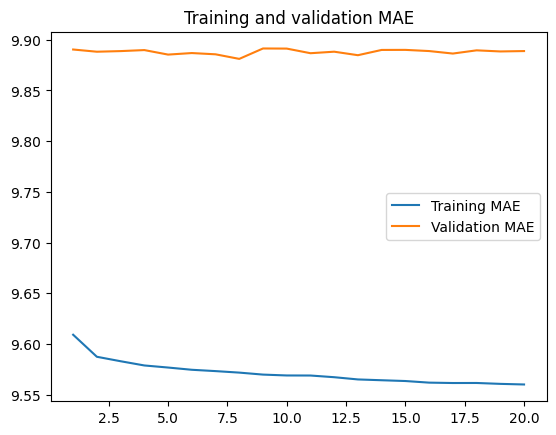


405/405 [==============================] - 45s 107ms/step - loss: 151.2476 - mae: 9.9209
Test MAE: 9.92

Training with LSTM Unit:  40
Epoch 1/20
819/819 [==============================] - 357s 430ms/step - loss: 137.1860 - mae: 9.6065 - val_loss: 143.9198 - val_mae: 9.8881
Epoch 2/20
819/819 [==============================] - 369s 450ms/step - loss: 136.9369 - mae: 9.5840 - val_loss: 143.9332 - val_mae: 9.8888
Epoch 3/20
819/819 [==============================] - 359s 438ms/step - loss: 136.8956 - mae: 9.5759 - val_loss: 143.9095 - val_mae: 9.8878
Epoch 4/20
819/819 [==============================] - 357s 436ms/step - loss: 136.8805 - mae: 9.5723 - val_loss: 143.9315 - val_mae: 9.8926
Epoch 5/20
819/819 [==============================] - 361s 440ms/step - loss: 136.8714 - mae: 9.5699 - val_loss: 143.8777 - val_mae: 9.8839
Epoch 6/20
819/819 [==============================] - 364s 445ms/step - loss: 136.8582 - mae: 9.5673 - val_loss: 143.9063 - val_mae: 9.8884
Epoch 7/20
819/819 [=====

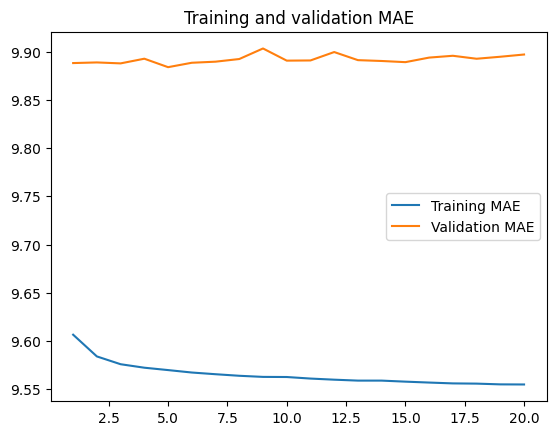


405/405 [==============================] - 61s 148ms/step - loss: 151.2502 - mae: 9.9219
Test MAE: 9.92



In [21]:
for lstm_unit in [10,25,40]:

    tf.keras.backend.clear_session()

    reusable_LSTM = tf.keras.layers.LSTM(lstm_unit)         # define our reusable layer

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1])) #inputs


    left_ouput = reusable_LSTM(inputs)           #    → reusable layer

    right_output = reusable_LSTM(inputs)        #    → reusable layer

    merged = tf.keras.layers.concatenate(            # 3. concatenate
        [left_ouput, right_output], axis=-1
    )
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

    model = tf.keras.Model(inputs, predictions)

    print("Training with LSTM Unit: ", lstm_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_rnn.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_rnn.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with LSTM Unit:  55
Epoch 1/20
819/819 [==============================] - 485s 584ms/step - loss: 137.1302 - mae: 9.6027 - val_loss: 143.8759 - val_mae: 9.8837
Epoch 2/20
819/819 [==============================] - 463s 565ms/step - loss: 136.9298 - mae: 9.5827 - val_loss: 143.9252 - val_mae: 9.8904
Epoch 3/20
819/819 [==============================] - 463s 565ms/step - loss: 136.8972 - mae: 9.5764 - val_loss: 143.8997 - val_mae: 9.8875
Epoch 4/20
819/819 [==============================] - 465s 568ms/step - loss: 136.8715 - mae: 9.5714 - val_loss: 143.8894 - val_mae: 9.8850
Epoch 5/20
819/819 [==============================] - 464s 566ms/step - loss: 136.8591 - mae: 9.5680 - val_loss: 143.8839 - val_mae: 9.8831
Epoch 6/20
819/819 [==============================] - 466s 569ms/step - loss: 136.8489 - mae: 9.5652 - val_loss: 143.9014 - val_mae: 9.8859
Epoch 7/20
819/819 [==============================] - 462s 564ms/step - loss: 136.8381 - mae: 9.5621 - val_loss: 143.8929 - val_mae

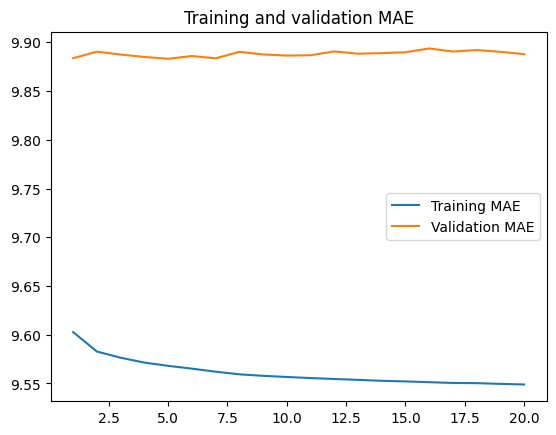


405/405 [==============================] - 79s 191ms/step - loss: 151.2523 - mae: 9.9217
Test MAE: 9.92

Training with LSTM Unit:  70
Epoch 1/20
819/819 [==============================] - 535s 647ms/step - loss: 137.0932 - mae: 9.6018 - val_loss: 143.8858 - val_mae: 9.8840
Epoch 2/20
819/819 [==============================] - 580s 708ms/step - loss: 136.9465 - mae: 9.5855 - val_loss: 143.8999 - val_mae: 9.8859
Epoch 3/20
819/819 [==============================] - 579s 706ms/step - loss: 136.9048 - mae: 9.5774 - val_loss: 143.8952 - val_mae: 9.8854
Epoch 4/20
819/819 [==============================] - 578s 706ms/step - loss: 136.8693 - mae: 9.5691 - val_loss: 143.8728 - val_mae: 9.8819
Epoch 5/20
819/819 [==============================] - 578s 706ms/step - loss: 136.8514 - mae: 9.5653 - val_loss: 143.9142 - val_mae: 9.8867
Epoch 6/20
819/819 [==============================] - 577s 704ms/step - loss: 136.8369 - mae: 9.5621 - val_loss: 143.8900 - val_mae: 9.8850
Epoch 7/20
819/819 [=====

In [ ]:
for lstm_unit in [55,70,100]:

    tf.keras.backend.clear_session()

    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1])) #inputs


    reusable_LSTM = tf.keras.layers.LSTM(lstm_unit)         # define our reusable layer

    left_ouput = reusable_LSTM(inputs)           #    → reusable layer

    right_output = reusable_LSTM(inputs)        #    → reusable layer
    merged = tf.keras.layers.concatenate(            # 3. concatenate
        [left_ouput, right_output], axis=-1
    )
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

    model = tf.keras.Model(inputs, predictions)

    print("Training with LSTM Unit: ", lstm_unit)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(base_dir / "jena_lstm_rnn.h5"),
            save_best_only=True
        )
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_lstm_rnn.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

### Result of Network 8:
Common-sense baseline:  `2.59`

| Experiment number | Lstm unit | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | 10| 9.93 | No|
| 2 | 25 | 9.92 | Yes (by 0.10)|
| 3 | 40 | 9.92 | Yes (by 0.11)|
| 4 | 55 | 9.92 | Yes (by 0.11)|
(Couldn't do the other 2 due to it taking too long)

In Network 8 I tried using an Advanced best practice reusable layers and all the experiment fail to beat the common-sense baseline the worst experiment was experiment 1 with a test MAE of 9.93 and the best was experiment 2,3 and 4 with a test MAE of 9.92 these are huge losses compared to previous networks

### Network 9 - Advanced Best Practices - Conv1D (Using 2D would take too long due to reshaping data around 15mins per epoch ) - Different Lstm Units at Epoch 20,0.25 dropout rate and regularizer rate of 0.15

In [25]:
def conv_1d(dropout_rate,regularizers,size_list):

    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2),
        ]
    )


    inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = data_augmentation(inputs)

    x = tf.keras.layers.Rescaling(1./255)(x)
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, use_bias=False)(x)

    for size in size_list:
        residual = x                                                                    # ← RESIDUAL

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv1D(size, 3, padding="same", use_bias=False,kernel_regularizer=tf.keras.regularizers.L2(regularizers))(x) # ← SEPARABLE CONV
        x = tf.keras.layers.Dropout(dropout_rate)(x)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv1D(size, 3, padding="same", use_bias=False,kernel_regularizer=tf.keras.regularizers.L2(regularizers))(x) # ← SEPARABLE CONV
        x = tf.keras.layers.Dropout(dropout_rate)(x)

        x = tf.keras.layers.MaxPooling1D(3, strides=2, padding="same")(x)

        residual = tf.keras.layers.Conv1D(                                              # reshape the residual
            size, 1, strides=2, padding="same", use_bias=False
        )(residual)
        x = tf.keras.layers.add([x, residual])                                          # ← REINJECTED

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=["accuracy"]
    )

    print("Training with LSTM Unit: ", size)
    callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(base_dir / "jena_conv2d.h5"),
                save_best_only=True
            )
        ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(
            train_dataset,
            epochs=20,
            validation_data=val_dataset,
            callbacks=callbacks
        )
    plot_history(history)
    print()
    model = tf.keras.models.load_model(base_dir / "jena_conv2d.h5")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
    print("=" * 40)
    print()

Training with LSTM Unit:  15
Epoch 1/20
819/819 [==============================] - 174s 206ms/step - loss: 138.5952 - mae: 9.7061 - val_loss: 144.4535 - val_mae: 9.9461
Epoch 2/20
819/819 [==============================] - 180s 219ms/step - loss: 138.3647 - mae: 9.6971 - val_loss: 144.4535 - val_mae: 9.9461
Epoch 3/20
819/819 [==============================] - 182s 221ms/step - loss: 138.3648 - mae: 9.6971 - val_loss: 144.4534 - val_mae: 9.9461
Epoch 4/20
819/819 [==============================] - 165s 201ms/step - loss: 138.3647 - mae: 9.6971 - val_loss: 144.4534 - val_mae: 9.9461
Epoch 5/20
819/819 [==============================] - 163s 199ms/step - loss: 138.3649 - mae: 9.6970 - val_loss: 144.4534 - val_mae: 9.9461
Epoch 6/20
819/819 [==============================] - 162s 197ms/step - loss: 138.3648 - mae: 9.6971 - val_loss: 144.4535 - val_mae: 9.9461
Epoch 7/20
819/819 [==============================] - 173s 211ms/step - loss: 138.3647 - mae: 9.6971 - val_loss: 144.4534 - val_mae

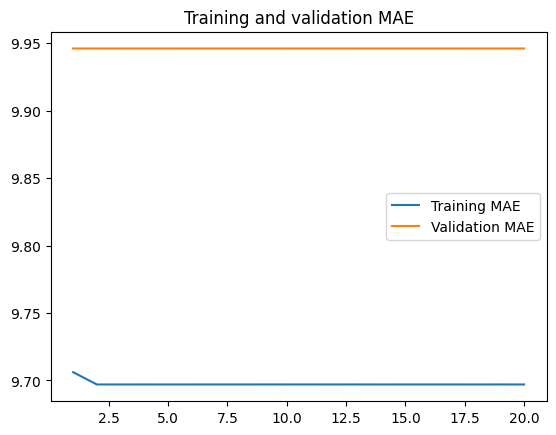


405/405 [==============================] - 26s 62ms/step - loss: 151.3600 - mae: 9.9299
Test MAE: 9.93



In [26]:
size_list = [5,10,15]
conv_1d(0.25,0.15,size_list)

### Result of Network 9:
Common-sense baseline:  `2.59`

| Experiment number | Size List | Test MAE |Did it beat the common-sense baseline? |
| --- | --- | --- | --- |
| 1 | [5,10,15]| 9.93 | No|

In this nextwork I did 1 experiment using conv1D and it failed to beat the common-sense baseline with a Test MAE of 9.92 and a huge loss of 151.3600

---

## 2. Text classification with a Transformer

1. Download the data and load it into datasets as is done in section 11.3.1 (there is a modified version of the dataset-building code in the lecture notebooks):
    ```bash
    !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xf aclImdb_v1.tar.gz
    !rm -r aclImdb/train/unsup
    ```  
       
    Note that if you already downloaded this data for previous experiments, you can create a symlink:
    ```bash
    ln -s path/to/aclImdb [newName]
    ```

2. Import the code for text classification with the Transformer Encoder from listings 11.21, 11.24 and 11.25 and train it.

3. Experiment with different hyperparameters. How do the results compare with the first method we used in Topic 3 (you can find experiments in the lecture notebook `3-getting-started/04.1.classifying-movie-reviews-imdb.ipynb`)?

4. Suggestions for experiments:

    - Reproduce the steps from DLPW listings 11.12 and 11.17, and compare the performance of your bidirectional LSTM with the transformer you built above.
    - Test pretrained embeddings: download the *GloVe* file as described in listing 11.18 and 11.19. The comment after listing 11.20 mentions that in this case, the *GloVe* embeddings do not make much of a difference. Can you reproduce this result? If you reduce the size of your dataset, do you notice a threshold at which the model pretrained embedding works better than the one trained from scratch?
    - Reproduce the steps from DLWP section 11.3 (using the model-building utility from listing 11.5), and compare your results with what you have:
        - Create a bag-of-word model (listing 11.3);
        - Create a n-grams (n > 1) model (listings 11.7 and 11.8).
    - Advanced: can you modify and encapsulate your Transformer model so that it is easier to change its architecture (number of layers, number of heads, etc.)?
    


### Conclusion:

In Conclusion I did 9 Networks and during my experimentation I found out that in Network 1 20 epoch was the best epoch to use, in Network 3 the best dropout rate was 0.25, In Network 4 I discovered that the best regularizer rate was 0.15, GRU units(Network 5,6 and 7) gave me a better test MAE compared to Lstm(Network 2) which I found out in Network 7 that the bets GRU unit was 150.Advanced best practices didn't go well for me I got huge losses and they were the worst experiments overall these are Networks 9 and 8.

**Network 7 Experiment 3 was the best experiment as it achieved an Test MAE of 2.42 and the smallest loss of 9.9881**

Training with GRU Unit:  150
Epoch 1/20
819/819 [==============================] - 913s 1s/step - loss: 16.2246 - mae: 2.8355 - val_loss: 10.1947 - val_mae: 2.4351
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 890s 1s/step - loss: 11.1654 - mae: 2.5825 - val_loss: 9.9297 - val_mae: 2.4417
Epoch 3/20
819/819 [==============================] - 888s 1s/step - loss: 10.6910 - mae: 2.5348 - val_loss: 8.9795 - val_mae: 2.3073
Epoch 4/20
819/819 [==============================] - 893s 1s/step - loss: 10.4383 - mae: 2.5034 - val_loss: 8.9453 - val_mae: 2.3015
Epoch 5/20
819/819 [==============================] - 887s 1s/step - loss: 10.2417 - mae: 2.4754 - val_loss: 8.7695 - val_mae: 2.2666
Epoch 6/20
819/819 [==============================] - 885s 1s/step - loss: 10.0647 - mae: 2.4509 - val_loss: 9.1983 - val_mae: 2.3265
Epoch 7/20
819/819 [==============================] - 847s 1s/step - loss: 9.8812 - mae: 2.4264 - val_loss: 9.1762 - val_mae: 2.3246
Epoch 8/20
819/819 [==============================] - 891s 1s/step - loss: 9.7294 - mae: 2.4032 - val_loss: 8.9904 - val_mae: 2.2845
Epoch 9/20
819/819 [==============================] - 904s 1s/step - loss: 

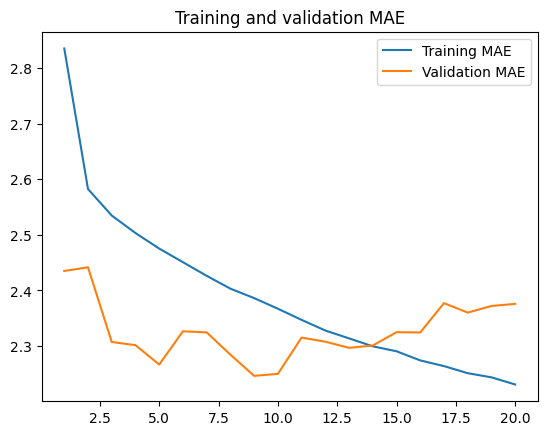


405/405 [==============================] - 104s 255ms/step - loss: 10.0090 - mae: 2.4381
Test MAE: 2.44
819/819 [==============================] - 205s 249ms/step - loss: 8.7503 - mae: 2.2712
Train MAE: 2.27
408/408 [==============================] - 99s 243ms/step - loss: 8.7356 - mae: 2.2463
Val MAE: 2.25



In [27]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.GRU(150, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
x = tf.keras.layers.GRU(150, recurrent_regularizer=tf.keras.regularizers.L2(0.15),recurrent_dropout=0.25)(inputs)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

print("Training with GRU Unit: ", 150)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "jena_lstm_l2.h5"),
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

plot_history(history)
print()
model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
print(f"Train MAE: {model.evaluate(train_dataset)[1]:.2f}")
print(f"Val MAE: {model.evaluate(val_dataset)[1]:.2f}")

print("=" * 40)
print()

##1

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!ln -s /path/to/already/downloaded/dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.1M      0  0:00:07  0:00:07 --:--:-- 16.0M
ln: failed to create symbolic link './dataset': File exists


##2

---

#### Remember to run your best performing models on the test set.

## EXTERNAL DATA (Didn't get to finish it)

## STARTS HERE

!gdown wasn't working for me anymore I tried google to figure it out and it gave me other ways such as "!gdown 10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv.zip" using -O but it wasn't working to find the diabetes.csv file so I asked ChatGPT the following questions:

(I pretty much send it what code I was user and the error I was getting and the last answer worked)

## ChatGPT (3.5, free version,12/01/2024)

#[Question]
!gdown 10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv.zip
#[Answer]
ChatGPT:

It appears you're trying to download a file named diabetes.csv.zip from Google Drive using the gdown command. This command should work if the file is shared publicly. However, if the file is not publicly accessible, you might need to adjust the sharing settings on Google Drive.

Here's the corrected command:

bash
Copy code
!gdown --id 10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv.zip
This command specifies the file ID using --id and sets the output file name to diabetes.csv.zip with -O. Make sure the file is shared publicly or that you have the necessary permissions to access it. If you encounter any issues, double-check the sharing settings on Google Drive and adjust them accordingly.



#[Question]
User:

!gdown --id 10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv
#[Answer]
ChatGPT:

It looks like you're attempting to download a file named diabetes.csv from Google Drive using the gdown command. This command should work if the file is shared publicly or if you have the necessary permissions.

Here's the corrected command:

bash
Copy code
!gdown --id 10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv
This command specifies the file ID using --id and sets the output file name to diabetes.csv with -O. Please ensure that the file is publicly accessible or that you have the appropriate permissions to download it. If you encounter any issues, check the sharing settings on Google Drive and adjust them accordingly.
#[Question]
User:

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 156, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 259, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'
#[Answer]
ChatGPT:

It seems there's an issue with the gdown command, and it may be related to a change in the way it handles file IDs. The warning you received indicates that the --id option has been deprecated, and the error suggests a problem with extracting the filename from the URL.

You can try using the following command instead:

bash
Copy code
!gdown https://drive.google.com/uc?id=10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv
This command directly uses the file ID in the URL without the --id option, which should be in line with the deprecation warning. Please replace diabetes.csv with the desired output filename.

If the problem persists, you might want to check for updates to the gdown package or consult the package's documentation for any changes in usage.
#[Question]
User:

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 156, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 259, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'
#[Answer]
ChatGPT:

It seems like there might be an issue with the gdown command or how it handles the download URL. To address this, you can try an alternative approach using Python code to download the file. Below is an example of how you can achieve this using the requests library:

python
Copy code
import requests

file_id = "10izcTbI9UDxbJretAXP6QejYa9c2mQME"
url = f"https://drive.google.com/uc?id={file_id}"

output_file = "diabetes.csv"

response = requests.get(url)
with open(output_file, 'wb') as f:
    f.write(response.content)

print(f"File '{output_file}' downloaded successfully.")
Before running this code, make sure to install the requests library if you haven't already:

bash
Copy code
pip install requests
This script uses the requests library to download the file directly. Replace the file_id with the correct ID and adjust the output_file variable as needed. If you encounter any issues or if you have additional requirements, please let me know.

In [ ]:
import requests

file_id = "10izcTbI9UDxbJretAXP6QejYa9c2mQME"
url = f"https://drive.google.com/uc?id={file_id}"

output_file = "diabetes.csv"

response = requests.get(url)
with open(output_file, 'wb') as f:
    f.write(response.content)

print(f"File '{output_file}' downloaded successfully.")


File 'diabetes.csv' downloaded successfully.


In [ ]:
!gdown https://drive.google.com/uc?id=10izcTbI9UDxbJretAXP6QejYa9c2mQME -O diabetes.csv


Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 156, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 259, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'


In [ ]:
import os
os.listdir()

['.config',
 'jena',
 'jena_climate_2009_2016.csv.zip',
 'view?usp=sharing',
 'aclImdb_v1.tar.gz',
 'dataset',
 'diabetes.csv',
 'uc?export=download',
 'aclImdb',
 'sample_data']

In [ ]:
!unzip diabetes.csv

Archive:  diabetes.csv
replace diabetes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: diabetes.csv            


In [ ]:
with open("diabetes.csv") as i:
  data = i.read().split("\n")

In [ ]:
print (data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
data_split = [l.split(",") for l in data]

In [ ]:
headers = data_split[0]
data_ready = data_split[1:]

converted_data = []
for d in data_ready:
  new_d = []
  for l in d:
    new_d.append(float(l))

  converted_data.append(new_d)

In [ ]:
print(headers)
print(data_ready)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
[['6', '148', '72', '35', '0', '33.6', '0.627', '50', '1'], ['1', '85', '66', '29', '0', '26.6', '0.351', '31', '0'], ['8', '183', '64', '0', '0', '23.3', '0.672', '32', '1'], ['1', '89', '66', '23', '94', '28.1', '0.167', '21', '0'], ['0', '137', '40', '35', '168', '43.1', '2.288', '33', '1'], ['5', '116', '74', '0', '0', '25.6', '0.201', '30', '0'], ['3', '78', '50', '32', '88', '31', '0.248', '26', '1'], ['10', '115', '0', '0', '0', '35.3', '0.134', '29', '0'], ['2', '197', '70', '45', '543', '30.5', '0.158', '53', '1'], ['8', '125', '96', '0', '0', '0', '0.232', '54', '1'], ['4', '110', '92', '0', '0', '37.6', '0.191', '30', '0'], ['10', '168', '74', '0', '0', '38', '0.537', '34', '1'], ['10', '139', '80', '0', '0', '27.1', '1.441', '57', '0'], ['1', '189', '60', '23', '846', '30.1', '0.398', '59', '1'], ['5', '166', '72', '19', '175', '25.8', '0.587', '51', 

In [ ]:
for i,feature in enumerate(headers):
  if feature == "Glucose":
    print(f"{i:<2} | \033[1;3m{feature} ← This is the set data I'm using\033[0m")
  else:
    print(f"{i:<2} | {feature}")

print()
print(f"{len(data_ready)} lines")

0  | Pregnancies
1  | Glucose ← This is the set data I'm using
2  | BloodPressure
3  | SkinThickness
4  | Insulin
5  | BMI
6  | DiabetesPedigreeFunction
7  | Age
8  | Outcome

768 lines


In [ ]:
import numpy as np


In [ ]:
full_data = np.array(converted_data)

In [ ]:
full_data.shape

(768, 9)

## :,:-1 - "not everything up until the last one not including it."

In [ ]:
full_data[:,-1] ##full

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 0.

In [ ]:
coloumn_names = [
    'Preg','Glucose','BloodP','SkinT','Insulin','BMI','DPF','Age','Outcome'
]
for name in coloumn_names[:]:
    print(f"{name:>10}",end="")
print()
print("-" * 90)
for row in range(10):
    for col in range(9):
      x = full_data[row, col]
      print(f"{x:10.4f}", end="")
    print()

      Preg   Glucose    BloodP     SkinT   Insulin       BMI       DPF       Age   Outcome
------------------------------------------------------------------------------------------
    6.0000  148.0000   72.0000   35.0000    0.0000   33.6000    0.6270   50.0000    1.0000
    1.0000   85.0000   66.0000   29.0000    0.0000   26.6000    0.3510   31.0000    0.0000
    8.0000  183.0000   64.0000    0.0000    0.0000   23.3000    0.6720   32.0000    1.0000
    1.0000   89.0000   66.0000   23.0000   94.0000   28.1000    0.1670   21.0000    0.0000
    0.0000  137.0000   40.0000   35.0000  168.0000   43.1000    2.2880   33.0000    1.0000
    5.0000  116.0000   74.0000    0.0000    0.0000   25.6000    0.2010   30.0000    0.0000
    3.0000   78.0000   50.0000   32.0000   88.0000   31.0000    0.2480   26.0000    1.0000
   10.0000  115.0000    0.0000    0.0000    0.0000   35.3000    0.1340   29.0000    0.0000
    2.0000  197.0000   70.0000   45.0000  543.0000   30.5000    0.1580   53.0000    1.0000

In [ ]:
c = np.stack([data_ready,full_data,data_ready])
c

array([[['6', '148', '72', ..., '0.627', '50', '1'],
        ['1', '85', '66', ..., '0.351', '31', '0'],
        ['8', '183', '64', ..., '0.672', '32', '1'],
        ...,
        ['5', '121', '72', ..., '0.245', '30', '0'],
        ['1', '126', '60', ..., '0.349', '47', '1'],
        ['1', '93', '70', ..., '0.315', '23', '0']],

       [['6.0', '148.0', '72.0', ..., '0.627', '50.0', '1.0'],
        ['1.0', '85.0', '66.0', ..., '0.351', '31.0', '0.0'],
        ['8.0', '183.0', '64.0', ..., '0.672', '32.0', '1.0'],
        ...,
        ['5.0', '121.0', '72.0', ..., '0.245', '30.0', '0.0'],
        ['1.0', '126.0', '60.0', ..., '0.349', '47.0', '1.0'],
        ['1.0', '93.0', '70.0', ..., '0.315', '23.0', '0.0']],

       [['6', '148', '72', ..., '0.627', '50', '1'],
        ['1', '85', '66', ..., '0.351', '31', '0'],
        ['8', '183', '64', ..., '0.672', '32', '1'],
        ...,
        ['5', '121', '72', ..., '0.245', '30', '0'],
        ['1', '126', '60', ..., '0.349', '47', '1'],
 

In [ ]:
all_labels = c[:,300]
all_labels

array([['0', '167', '0', '0', '0', '32.3', '0.839', '30', '1'],
       ['0.0', '167.0', '0.0', '0.0', '0.0', '32.3', '0.839', '30.0',
        '1.0'],
       ['0', '167', '0', '0', '0', '32.3', '0.839', '30', '1']],
      dtype='<U32')

In [ ]:
c[:,:300]

array([[['6', '148', '72', ..., '0.627', '50', '1'],
        ['1', '85', '66', ..., '0.351', '31', '0'],
        ['8', '183', '64', ..., '0.672', '32', '1'],
        ...,
        ['0', '126', '84', ..., '0.52', '24', '0'],
        ['14', '100', '78', ..., '0.412', '46', '1'],
        ['8', '112', '72', ..., '0.84', '58', '0']],

       [['6.0', '148.0', '72.0', ..., '0.627', '50.0', '1.0'],
        ['1.0', '85.0', '66.0', ..., '0.351', '31.0', '0.0'],
        ['8.0', '183.0', '64.0', ..., '0.672', '32.0', '1.0'],
        ...,
        ['0.0', '126.0', '84.0', ..., '0.52', '24.0', '0.0'],
        ['14.0', '100.0', '78.0', ..., '0.412', '46.0', '1.0'],
        ['8.0', '112.0', '72.0', ..., '0.84', '58.0', '0.0']],

       [['6', '148', '72', ..., '0.627', '50', '1'],
        ['1', '85', '66', ..., '0.351', '31', '0'],
        ['8', '183', '64', ..., '0.672', '32', '1'],
        ...,
        ['0', '126', '84', ..., '0.52', '24', '0'],
        ['14', '100', '78', ..., '0.412', '46', '1'],
 

In [ ]:
c[:,400:]

array([[['4', '95', '64', ..., '0.161', '31', '1'],
        ['6', '137', '61', ..., '0.151', '55', '0'],
        ['5', '136', '84', ..., '0.286', '35', '1'],
        ...,
        ['5', '121', '72', ..., '0.245', '30', '0'],
        ['1', '126', '60', ..., '0.349', '47', '1'],
        ['1', '93', '70', ..., '0.315', '23', '0']],

       [['4.0', '95.0', '64.0', ..., '0.161', '31.0', '1.0'],
        ['6.0', '137.0', '61.0', ..., '0.151', '55.0', '0.0'],
        ['5.0', '136.0', '84.0', ..., '0.286', '35.0', '1.0'],
        ...,
        ['5.0', '121.0', '72.0', ..., '0.245', '30.0', '0.0'],
        ['1.0', '126.0', '60.0', ..., '0.349', '47.0', '1.0'],
        ['1.0', '93.0', '70.0', ..., '0.315', '23.0', '0.0']],

       [['4', '95', '64', ..., '0.161', '31', '1'],
        ['6', '137', '61', ..., '0.151', '55', '0'],
        ['5', '136', '84', ..., '0.286', '35', '1'],
        ...,
        ['5', '121', '72', ..., '0.245', '30', '0'],
        ['1', '126', '60', ..., '0.349', '47', '1'],
 

In [ ]:
all_features = np.hstack([c[:,:300], c[:,400:]])
all_features.shape, all_features

((3, 668, 9),
 array([[['6', '148', '72', ..., '0.627', '50', '1'],
         ['1', '85', '66', ..., '0.351', '31', '0'],
         ['8', '183', '64', ..., '0.672', '32', '1'],
         ...,
         ['5', '121', '72', ..., '0.245', '30', '0'],
         ['1', '126', '60', ..., '0.349', '47', '1'],
         ['1', '93', '70', ..., '0.315', '23', '0']],
 
        [['6.0', '148.0', '72.0', ..., '0.627', '50.0', '1.0'],
         ['1.0', '85.0', '66.0', ..., '0.351', '31.0', '0.0'],
         ['8.0', '183.0', '64.0', ..., '0.672', '32.0', '1.0'],
         ...,
         ['5.0', '121.0', '72.0', ..., '0.245', '30.0', '0.0'],
         ['1.0', '126.0', '60.0', ..., '0.349', '47.0', '1.0'],
         ['1.0', '93.0', '70.0', ..., '0.315', '23.0', '0.0']],
 
        [['6', '148', '72', ..., '0.627', '50', '1'],
         ['1', '85', '66', ..., '0.351', '31', '0'],
         ['8', '183', '64', ..., '0.672', '32', '1'],
         ...,
         ['5', '121', '72', ..., '0.245', '30', '0'],
         ['1', '126

In [ ]:
train_data, test_data = all_features[:300], all_features[7:]
train_data,test_data

(array([[['6', '148', '72', ..., '0.627', '50', '1'],
         ['1', '85', '66', ..., '0.351', '31', '0'],
         ['8', '183', '64', ..., '0.672', '32', '1'],
         ...,
         ['5', '121', '72', ..., '0.245', '30', '0'],
         ['1', '126', '60', ..., '0.349', '47', '1'],
         ['1', '93', '70', ..., '0.315', '23', '0']],
 
        [['6.0', '148.0', '72.0', ..., '0.627', '50.0', '1.0'],
         ['1.0', '85.0', '66.0', ..., '0.351', '31.0', '0.0'],
         ['8.0', '183.0', '64.0', ..., '0.672', '32.0', '1.0'],
         ...,
         ['5.0', '121.0', '72.0', ..., '0.245', '30.0', '0.0'],
         ['1.0', '126.0', '60.0', ..., '0.349', '47.0', '1.0'],
         ['1.0', '93.0', '70.0', ..., '0.315', '23.0', '0.0']],
 
        [['6', '148', '72', ..., '0.627', '50', '1'],
         ['1', '85', '66', ..., '0.351', '31', '0'],
         ['8', '183', '64', ..., '0.672', '32', '1'],
         ...,
         ['5', '121', '72', ..., '0.245', '30', '0'],
         ['1', '126', '60', ..., 

## Standardisation/ Normalisation

In [ ]:
(full_data, train_targets), (test_data, test_targets) = diabetes.csv.load_data()
print(full_data.shape, test_data.shape)

NameError: name 'diabetes' is not defined

In [ ]:
print(full_data[0])

[  6.    148.     72.     35.      0.     33.6     0.627  50.      1.   ]


In [ ]:
mean = full_data.mean(axis=0) # axis 0: along each feature axis!
full_data -= mean             # shift
std = full_data.std(axis=0)
full_data /= std              # rescale

test_data -= mean              # use the mean & std
test_data /= std               # of our training set

NameError: ignored

In [ ]:
def stats(x):
    mean = sum(x) / len(x)                          # compute the mean
    deviations = x - mean                           # deviations can be positive or negative
    avg_sq_deviations = sum(deviations**2) / len(x) # we square them and take the mean
    std = np.sqrt(avg_sq_deviations)                # then we take the square root
    return mean, std

In [ ]:
def normalise(x):
    mean, std = stats(x)
    return (x - mean) / std, mean, std # subtract the mean, divide by the standard deviation

In [ ]:
def plot_mean_std(nums):
    nums_norm, mean, std = normalise(nums)

    fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(16,3))

    ax1.bar([str(x) for x in range(nums.shape[0])], nums)                              # our numbers
    ax1.set_title(f"Original numbers | mean: {mean:.2f}, std: {std:.2f}")
    ax1.plot([mean] * nums.shape[0], linestyle='solid', color="r", label="mean")       # the mean
    ax1.plot([mean + std] * nums.shape[0], linestyle='dotted', color="r", label="std") # mean + std
    ax1.plot([mean - std] * nums.shape[0], linestyle='dotted', color="r")              # mean - std
    ax1.legend()

    ax2.bar([str(x) for x in range(nums_norm.shape[0])], nums_norm)                    # our numbers normalised
    ax2.set_title(f"Normalized | mean: {nums_norm.mean():.2f}, std: {nums_norm.std():.2f}")
    plt.show()